# Intro to 2D CNNs
A description and demo notebook to go through creating a 2D CNN and using it with dummy data

## 0. Setting up dummy data

Before learning how to use the cores, let's create a dummy data images. This data will be similar to a batch of images.

Throughout the notebook we will refer to the elements of this shape in the following manner:

[1] is the number of channels (can be input, hidden, output)

[144] is the height of image or feature maps

[256] is the height of image or feature maps

[32] is the batch size, which is not as relevant for understanding the material in this notebook.

In [1]:
# To access to neuropixel_predictor
import sys
import os
sys.path.append('../')

# Basic imports
import warnings
import random

# Essential imports
import numpy as np
import torch

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)
device = "cuda" if torch.cuda.is_available() else "cpu"
random_seed = 42

## 1. Setting Up the data

In [3]:
IMAGE_WIDTH = 36
IMAGE_HEIGHT = 22

images = torch.ones(32, 1, IMAGE_WIDTH, IMAGE_HEIGHT)


## 2. Using Stacked 2D Core

In [4]:
stacked2dcore_config = {
    # core args
    'input_channels': 1,
    'input_kern': 7,
    'hidden_kern': 5,
    'hidden_channels': 64,
    'layers': 3,
    'stack': -1,
    'pad_input': True,
    'gamma_input': 6.3831
}

In [5]:
# from neuralpredictors.layers.cores import Stacked2dCore
# from neuralpredictors.utils import get_module_output

# core = Stacked2dCore(input_channels=1,
#                      hidden_channels=64,
#                      input_kern=9,
#                      hidden_kern=7)

# in_shape_dict = {k: get_module_output(core, in_shape)[1:] for k, in_shape in in_shapes_dict.items()}



from neuropixel_predictor.layers.cores import Stacked2dCore 

stacked2d_core = Stacked2dCore(**stacked2dcore_config)
stacked2d_core

Stacked2dCore(
  (_input_weights_regularizer): LaplaceL2(
    (laplace): Laplace()
  )
  (features): Sequential(
    (layer0): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
  )
) [Stacked2dCore regularizers: gamma_hidden = 0|gamma_input = 6.3831|skip = 0]

In [6]:
# Trying out on images
stacked2dcore_out = stacked2d_core(images)
print(stacked2dcore_out.shape)

torch.Size([32, 64, 36, 22])


## 3. Using Readout to attach Factorized Readout

In [7]:
from neuropixel_predictor.layers.readouts import FullFactorized2d, MultiReadoutBase

In [8]:
in_shapes_dict = {
    '2023-03-15_11-05-00': torch.Size([64, IMAGE_WIDTH, IMAGE_HEIGHT]),
    # '2023-03-15_15-23': torch.Size([64, 150, 200])
}

n_neurons_dict = {
    '2023-03-15_11-05-00': 453,
    # '2023-03-15_15-23': 200
}

In [9]:
factorized_readout = MultiReadoutBase(
    in_shape_dict=in_shapes_dict,
    n_neurons_dict=n_neurons_dict,
    base_readout=FullFactorized2d,
    bias=True,
)

## 4. Invoke core and readout (dummy data)

In [10]:
# Forward pass with core
core_output = stacked2d_core(images)

# Forward pass with readout
readout_output_sample = factorized_readout(core_output, data_key="2023-03-15_11-05-00")

readout_output_sample

tensor([[ 1.3707e-03,  2.7188e-04,  2.5216e-05,  ..., -1.1725e-03,
         -8.6930e-03,  4.8162e-03],
        [ 1.3707e-03,  2.7188e-04,  2.5216e-05,  ..., -1.1725e-03,
         -8.6930e-03,  4.8162e-03],
        [ 1.3707e-03,  2.7188e-04,  2.5216e-05,  ..., -1.1725e-03,
         -8.6930e-03,  4.8162e-03],
        ...,
        [ 1.3707e-03,  2.7188e-04,  2.5216e-05,  ..., -1.1725e-03,
         -8.6930e-03,  4.8162e-03],
        [ 1.3707e-03,  2.7188e-04,  2.5216e-05,  ..., -1.1725e-03,
         -8.6930e-03,  4.8162e-03],
        [ 1.3707e-03,  2.7188e-04,  2.5216e-05,  ..., -1.1725e-03,
         -8.6930e-03,  4.8162e-03]], grad_fn=<AddBackward0>)

## 5. Testing with test data (from sinzlab)
Utility functions from https://github.com/sinzlab/sensorium

In [11]:
# %%capture 
# !pip install git+https://github.com/sinzlab/sensorium.git

**Defining some helper functions to extract the data**

In [12]:
# # The following are minimal adaptations of three utility functions found in nnfabrik that we need to initialise
# # the core and readouts later on.

# def get_data(dataset_fn, dataset_config):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/builder.py#L87
#     for the original implementation and documentation if you are interested.
#     """
#     return dataset_fn(**dataset_config)

# def get_dims_for_loader_dict(dataloaders):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/utility/nn_helpers.py#L39
#     for the original implementation and docstring if you are interested.
#     """
    
#     def get_io_dims(data_loader):
#         items = next(iter(data_loader))
#         if hasattr(items, "_asdict"):  # if it's a named tuple
#             items = items._asdict()

#         if hasattr(items, "items"):  # if dict like
#             return {k: v.shape for k, v in items.items()}
#         else:
#             return (v.shape for v in items)

#     return {k: get_io_dims(v) for k, v in dataloaders.items()}


# def set_random_seed(seed: int, deterministic: bool = True):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/utility/nn_helpers.py#L53
#     for the original implementation and docstring if you are intereseted.
#     """
#     random.seed(seed)
#     np.random.seed(seed)
#     if deterministic:
#         torch.backends.cudnn.benchmark = False
#         torch.backends.cudnn.deterministic = True
#     torch.manual_seed(seed)  # this sets both CPU and CUDA seeds for PyTorch

**Loading the data**

In [13]:
# ## Load the data: you can modify this if you have stored it in another location
# from sensorium.datasets import static_loaders

# DATA_PATH = '/Users/tarek/Documents/UNI/Lab Rotations/Kremkow/Data/Test/'

# filenames = [
#     DATA_PATH + 'static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip', 
#     DATA_PATH + 'static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip'
#     ]

# dataset_config = {'paths': filenames,
#                  'normalize': True,
#                  'include_behavior': False,
#                  'include_eye_position': True,
#                  'batch_size': 32,
#                  'scale':1,
#                  'cuda': True if device == 'cuda' else False,
#                  }

# dataloaders = get_data(dataset_fn=static_loaders, dataset_config=dataset_config)

In [14]:
# datapoint = list(dataloaders['train']['21067-10-18'])[0]
# images = datapoint[0]
# responses = datapoint[1]
# images.shape, responses.shape

**Process the data step by step**

In [15]:
# # We only need the train dataloaders to extract the session keys (could also use test or validation for this)
# train_dataloaders = dataloaders["train"]

# # Obtain the named tuple fields from the first entry of the first dataloader in the dictionary
# example_batch = next(iter(list(train_dataloaders.values())[0]))
# in_name, out_name = (
#     list(example_batch.keys())[:2] if isinstance(example_batch, dict) else example_batch._fields[:2]
# )

# session_shape_dict = get_dims_for_loader_dict(train_dataloaders)
# input_channels = [v[in_name][1] for v in session_shape_dict.values()]

# core_input_channels = (
#     list(input_channels.values())[0]
#     if isinstance(input_channels, dict)
#     else input_channels[0]
# )

**Core: Define Config Params**

In [16]:
# stacked2dcore_config = {
#     # core args
#     'input_kern': 7,
#     'hidden_kern': 5,
#     'hidden_channels': 64,
#     'layers': 3,
#     'stack': -1,
#     'pad_input': True,
#     'gamma_input': 6.3831
# }

**Core: Setting up**

In [17]:
# set_random_seed(random_seed)
# core = Stacked2dCore(
#     input_channels=core_input_channels,
#     **stacked2dcore_config,
# )
# core

**Core: Example forward pass**

In [18]:
# print(f"Sample batch shape: {example_batch.images.shape} (batch size, in_channels, in_height, in_width)")

# with torch.no_grad():
#     core_output = core(example_batch.images)
    
# print(f"Core output shape: {core_output.shape} (batch_size, out_channels, out_height, out_width)")


**Readout: Test the factorized**

In [19]:
# with torch.no_grad():
#     readout_output_sample = factorized_readout(core_output, data_key="21067-10-18")


# print(f"Readout output shape: {readout_output_sample.shape} (batch_size, n_neurons)")

--------------
--------------
--------------
## 6. Testing with our data

In [20]:
from torch.utils.data import DataLoader

TRAINING_DATA_DIR = '/Users/tarek/Documents/UNI/Lab Rotations/Kremkow/Data/Training'

# 1. Load the images and responses
training_images = np.load(os.path.join(TRAINING_DATA_DIR, 'training_images_2023-03-15_11-05.npy'))
training_responses = np.load(os.path.join(TRAINING_DATA_DIR, 'training_responses_2023-03-15_11-05.npy'))

test_images = np.load(os.path.join(TRAINING_DATA_DIR, 'test_images_2023-03-15_11-05.npy'))
test_responses = np.load(os.path.join(TRAINING_DATA_DIR, 'test_responses_2023-03-15_11-05.npy'))

training_images = training_images.reshape(training_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)
test_images = test_images.reshape(test_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)

# 2. Convert to tensors and typecast to float
training_images = torch.from_numpy(training_images).float()
test_images = torch.from_numpy(test_images).float()

training_responses = torch.from_numpy(training_responses).float()
test_responses = torch.from_numpy(test_responses).float()

# 3. Zip training and test
training_data = list(zip(training_images, training_responses))
test_data = list(zip(test_images, test_responses))
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False)

# 4. Load sample batch
images_batch, responses_batch = next(iter(train_dataloader))

# 5. Validate shape and types
training_images.shape, test_images.shape, images_batch.shape, responses_batch.shape, images_batch.type()

(torch.Size([8388, 1, 36, 22]),
 torch.Size([931, 1, 36, 22]),
 torch.Size([16, 1, 36, 22]),
 torch.Size([16, 453]),
 'torch.FloatTensor')

**Core: Define Config Params**

In [21]:
stacked2dcore_config = {
    # core args
    'input_channels': 1,
    'input_kern': 5,
    'hidden_kern': 3,
    'hidden_channels': 64,
    'layers': 3,
    'stack': -1,
    'pad_input': True,
    # 'gamma_input': 6.3831
}

**Core: Setting up**

In [22]:
core = Stacked2dCore(
    **stacked2dcore_config,
)
core

Stacked2dCore(
  (_input_weights_regularizer): LaplaceL2(
    (laplace): Laplace()
  )
  (features): Sequential(
    (layer0): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
  )
) [Stacked2dCore regularizers: gamma_hidden = 0|gamma_input = 0.0|skip = 0]

**Core: Example forward pass**

In [23]:
print(f"Sample batch shape: {images_batch.shape} (batch size, in_channels, in_height, in_width)")

with torch.no_grad():
    core_output = core(images_batch)
    
print(f"Core output shape: {core_output.shape} (batch_size, out_channels, out_height, out_width)")


Sample batch shape: torch.Size([16, 1, 36, 22]) (batch size, in_channels, in_height, in_width)
Core output shape: torch.Size([16, 64, 36, 22]) (batch_size, out_channels, out_height, out_width)


**Readout: Test the factorized**

In [24]:
with torch.no_grad():
    readout_output_sample = factorized_readout(core_output, data_key="2023-03-15_11-05-00")


print(f"Readout output shape: {readout_output_sample.shape} (batch_size, n_neurons)")

Readout output shape: torch.Size([16, 453]) (batch_size, n_neurons)


-------------
## 7. Training the model
Adopted similar usage from https://github.com/sinzlab/nnsysident/blob/master/notebooks/tutorial_mouse_models.ipynb

In [25]:
from neuropixel_predictor.training.trainers import simplified_trainer
from neuropixel_predictor.layers.encoders import GeneralizedEncoderBase
import torch.nn as nn

poisson_loss = nn.PoissonNLLLoss(log_input=False, full=True)
mse_loss = nn.MSELoss()
device = 'mps'

# trainer_config_base = {"track_training": True,
#                        "device": device,
#                        "detach_core": False}

In [26]:
model = GeneralizedEncoderBase(
    core,
    factorized_readout,
    elu=True
)

In [27]:
trained_model, training_history = simplified_trainer(
    model=model,
    train_loader=train_dataloader,
    val_loader=test_dataloader,
    loss_fn=poisson_loss,
    device=device,
    max_epochs=50,
    patience=10 # For the early stopping
)

Epoch 1/50 (Train):   0%|                                                                                | 0/525 [00:00<?, ?it/s]

PoissonNLLLoss()
responses mean/min/max: 2.9739696979522705 0.0 219.41488647460938
predictions mean/min/max: 1.000096321105957 0.9608075618743896 1.0327818393707275
-----
loss:  tensor(6.9580, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):   1%|▊                                                                       | 6/525 [00:00<00:33, 15.72it/s]

PoissonNLLLoss()
responses mean/min/max: 2.944601058959961 0.0 89.9400405883789
predictions mean/min/max: 1.0600459575653076 0.21606570482254028 2.8890132904052734
-----
loss:  tensor(7.0244, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.007748603820801 0.0 89.82035827636719
predictions mean/min/max: 1.220342755317688 0.016864001750946045 5.548507213592529
-----
loss:  tensor(4.7644, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3354451656341553 0.0 139.81358337402344
predictions mean/min/max: 1.2763159275054932 0.012512147426605225 7.324954986572266
-----
loss:  tensor(5.4327, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1638295650482178 0.0 109.92671203613281
predictions mean/min/max: 1.414163589477539 0.0021858811378479004 7.431461811065674
-----
loss:  tensor(7.1034, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1595003604888916 0.

Epoch 1/50 (Train):   3%|██▎                                                                    | 17/525 [00:00<00:14, 33.94it/s]

PoissonNLLLoss()
responses mean/min/max: 3.8655641078948975 0.0 99.8668441772461
predictions mean/min/max: 2.093602418899536 1.9609928131103516e-05 14.001951217651367
-----
loss:  tensor(7.4411, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5097262859344482 0.0 119.76048278808594
predictions mean/min/max: 2.1765711307525635 9.999999974752427e-07 16.02983856201172
-----
loss:  tensor(6.4650, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7494800090789795 0.0 99.83361053466797
predictions mean/min/max: 2.288294553756714 9.999999974752427e-07 17.266029357910156
-----
loss:  tensor(5.2442, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.418259859085083 0.0 169.60426330566406
predictions mean/min/max: 2.3880913257598877 9.999999974752427e-07 22.785587310791016
-----
loss:  tensor(6.1593, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.22096562385

Epoch 1/50 (Train):   5%|███▊                                                                   | 28/525 [00:00<00:12, 40.97it/s]

PoissonNLLLoss()
responses mean/min/max: 3.180232524871826 0.0 120.1201171875
predictions mean/min/max: 2.9069015979766846 9.999999974752427e-07 26.117055892944336
-----
loss:  tensor(5.0271, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3138484954833984 0.0 139.86013793945312
predictions mean/min/max: 2.9247357845306396 9.999999974752427e-07 39.917476654052734
-----
loss:  tensor(6.0882, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6242098808288574 0.0 199.60079956054688
predictions mean/min/max: 3.0425407886505127 9.999999974752427e-07 27.417585372924805
-----
loss:  tensor(6.3055, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.296851396560669 0.0 120.0400161743164
predictions mean/min/max: 3.1091368198394775 9.999999974752427e-07 28.1517391204834
-----
loss:  tensor(5.7168, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.24120712280273

Epoch 1/50 (Train):   7%|█████▎                                                                 | 39/525 [00:01<00:10, 45.35it/s]

tensor(5.8596, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.989564895629883 0.0 89.9400405883789
predictions mean/min/max: 3.433957576751709 9.999999974752427e-07 40.963356018066406
-----
loss:  tensor(5.0724, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6582982540130615 0.0 199.86676025390625
predictions mean/min/max: 3.4451427459716797 9.999999974752427e-07 40.363277435302734
-----
loss:  tensor(4.5354, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.644589900970459 0.0 99.83361053466797
predictions mean/min/max: 3.4136898517608643 9.999999974752427e-07 35.34114456176758
-----
loss:  tensor(5.1262, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.383871555328369 0.0 149.8501434326172
predictions mean/min/max: 3.4039103984832764 9.999999974752427e-07 31.57678985595703
-----
loss:  tensor(5.6959, device='mps:0', grad_fn=<MeanBackward0>)
Po

Epoch 1/50 (Train):  10%|██████▊                                                                | 50/525 [00:01<00:09, 47.72it/s]

PoissonNLLLoss()
responses mean/min/max: 3.529517889022827 0.0 119.48224639892578
predictions mean/min/max: 3.137073040008545 9.999999974752427e-07 56.12959671020508
-----
loss:  tensor(5.7800, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6501388549804688 0.0 169.71713256835938
predictions mean/min/max: 3.1798136234283447 9.999999974752427e-07 33.26246643066406
-----
loss:  tensor(5.6557, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0382728576660156 0.0 209.86009216308594
predictions mean/min/max: 3.219773769378662 9.999999974752427e-07 37.47677230834961
-----
loss:  tensor(5.3543, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7020113468170166 0.0 99.73403930664062
predictions mean/min/max: 3.238351821899414 9.999999974752427e-07 32.868125915527344
-----
loss:  tensor(4.7125, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8499245643615

Epoch 1/50 (Train):  12%|████████▍                                                              | 62/525 [00:01<00:09, 50.61it/s]

responses mean/min/max: 2.2298617362976074 0.0 109.96334838867188
predictions mean/min/max: 3.169445514678955 9.999999974752427e-07 36.54845428466797
-----
loss:  tensor(4.1918, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.543308734893799 0.0 129.826904296875
predictions mean/min/max: 3.0851857662200928 9.999999974752427e-07 50.72426986694336
-----
loss:  tensor(5.6317, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.999009370803833 0.0 129.87013244628906
predictions mean/min/max: 3.0665383338928223 9.999999974752427e-07 37.994903564453125
-----
loss:  tensor(4.6200, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.655745506286621 0.0 119.88011932373047
predictions mean/min/max: 3.034684181213379 9.999999974752427e-07 41.36787796020508
-----
loss:  tensor(5.4675, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3769407272338867 0.0 199.6007995

Epoch 1/50 (Train):  13%|█████████▏                                                             | 68/525 [00:01<00:09, 49.99it/s]

PoissonNLLLoss()
responses mean/min/max: 2.8241801261901855 0.0 99.63467407226562
predictions mean/min/max: 3.3927650451660156 9.999999974752427e-07 41.518070220947266
-----
loss:  tensor(4.5711, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.561563491821289 0.0 269.82012939453125
predictions mean/min/max: 3.391461133956909 9.999999974752427e-07 54.991207122802734
-----
loss:  tensor(5.4350, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.703031301498413 0.0 130.08673095703125
predictions mean/min/max: 3.457310914993286 9.999999974752427e-07 35.35798263549805
-----
loss:  tensor(5.8924, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.783827543258667 0.0 139.86013793945312
predictions mean/min/max: 3.4040262699127197 9.999999974752427e-07 34.34046936035156
-----
loss:  tensor(4.5966, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6814591884613

Epoch 1/50 (Train):  15%|██████████▊                                                            | 80/525 [00:01<00:08, 51.72it/s]

tensor(4.4889, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9137165546417236 0.0 110.14686584472656
predictions mean/min/max: 3.5320184230804443 9.999999974752427e-07 42.99258041381836
-----
loss:  tensor(4.7044, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4902820587158203 0.0 149.7504119873047
predictions mean/min/max: 3.3964133262634277 9.999999974752427e-07 48.14369583129883
-----
loss:  tensor(5.3182, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0542619228363037 0.0 129.826904296875
predictions mean/min/max: 3.3855950832366943 9.999999974752427e-07 34.69905471801758
-----
loss:  tensor(4.8814, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2502222061157227 0.0 144.83102416992188
predictions mean/min/max: 3.3615355491638184 9.999999974752427e-07 48.609256744384766
-----
loss:  tensor(5.0130, device='mps:0', grad_fn=<MeanBackward0>

Epoch 1/50 (Train):  18%|████████████▍                                                          | 92/525 [00:02<00:08, 51.59it/s]

PoissonNLLLoss()
responses mean/min/max: 3.0815634727478027 0.0 200.0
predictions mean/min/max: 3.1395018100738525 9.999999974752427e-07 39.65492248535156
-----
loss:  tensor(5.1287, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3749682903289795 0.0 109.92671203613281
predictions mean/min/max: 3.156796932220459 9.999999974752427e-07 46.304893493652344
-----
loss:  tensor(5.2861, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.2323663234710693 0.0 119.96001434326172
predictions mean/min/max: 3.1235711574554443 9.999999974752427e-07 40.08549880981445
-----
loss:  tensor(4.2460, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4866511821746826 0.0 119.56160736083984
predictions mean/min/max: 3.0728557109832764 9.999999974752427e-07 52.82012176513672
-----
loss:  tensor(4.7536, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4102046489715576 0.0 1

Epoch 1/50 (Train):  20%|█████████████▊                                                        | 104/525 [00:02<00:08, 52.18it/s]

PoissonNLLLoss()
responses mean/min/max: 3.068246841430664 0.0 119.96001434326172
predictions mean/min/max: 3.1615099906921387 9.999999974752427e-07 56.99781036376953
-----
loss:  tensor(4.8523, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.055422067642212 0.0 149.9000701904297
predictions mean/min/max: 3.0766472816467285 9.999999974752427e-07 36.37958908081055
-----
loss:  tensor(5.2812, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.296902656555176 0.0 140.14013671875
predictions mean/min/max: 3.018597364425659 9.999999974752427e-07 50.664527893066406
-----
loss:  tensor(5.0202, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.006019353866577 0.0 139.90672302246094
predictions mean/min/max: 3.0616469383239746 9.999999974752427e-07 36.519527435302734
-----
loss:  tensor(4.8898, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.382957696914673 

Epoch 1/50 (Train):  22%|███████████████▍                                                      | 116/525 [00:02<00:07, 52.81it/s]

PoissonNLLLoss()
responses mean/min/max: 3.6146607398986816 0.0 109.56175231933594
predictions mean/min/max: 3.1402127742767334 9.999999974752427e-07 34.23621368408203
-----
loss:  tensor(5.5763, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.513507843017578 0.0 179.22335815429688
predictions mean/min/max: 3.079982280731201 9.999999974752427e-07 49.5352897644043
-----
loss:  tensor(5.1254, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.050408840179443 0.0 110.22044372558594
predictions mean/min/max: 3.253038167953491 9.999999974752427e-07 36.47139358520508
-----
loss:  tensor(5.9877, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0221917629241943 0.0 110.18363952636719
predictions mean/min/max: 3.2642765045166016 9.999999974752427e-07 35.068748474121094
-----
loss:  tensor(4.8289, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4589338302612

Epoch 1/50 (Train):  23%|████████████████▎                                                     | 122/525 [00:02<00:07, 52.69it/s]

PoissonNLLLoss()
responses mean/min/max: 3.3486688137054443 0.0 110.29412078857422
predictions mean/min/max: 3.5399539470672607 9.999999974752427e-07 52.970184326171875
-----
loss:  tensor(5.6202, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5647528171539307 0.0 129.78369140625
predictions mean/min/max: 3.46451473236084 5.245208740234375e-06 42.76462173461914
-----
loss:  tensor(4.5571, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4203286170959473 0.0 160.0533447265625
predictions mean/min/max: 3.3815360069274902 9.999999974752427e-07 54.81826400756836
-----
loss:  tensor(5.0970, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0803794860839844 0.0 149.80026245117188
predictions mean/min/max: 3.3571178913116455 5.543231964111328e-06 40.886207580566406
-----
loss:  tensor(4.8758, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.6100835800170

Epoch 1/50 (Train):  26%|█████████████████▊                                                    | 134/525 [00:02<00:07, 51.18it/s]

PoissonNLLLoss()
responses mean/min/max: 3.3504798412323 0.0 120.0400161743164
predictions mean/min/max: 3.0264949798583984 9.999999974752427e-07 44.266448974609375
-----
loss:  tensor(4.8000, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.011676073074341 0.0 89.97000885009766
predictions mean/min/max: 2.9977195262908936 9.999999974752427e-07 46.729915618896484
-----
loss:  tensor(4.7883, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1485767364501953 0.0 109.85353088378906
predictions mean/min/max: 2.983281373977661 9.999999974752427e-07 49.17118453979492
-----
loss:  tensor(4.8901, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8365817070007324 0.0 169.71713256835938
predictions mean/min/max: 2.9401588439941406 9.999999974752427e-07 52.99273681640625
-----
loss:  tensor(5.7662, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.12142229080200

Epoch 1/50 (Train):  28%|███████████████████▍                                                  | 146/525 [00:03<00:07, 52.31it/s]

predictions mean/min/max: 3.3250131607055664 9.999999974752427e-07 48.69388198852539
-----
loss:  tensor(4.3316, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3885722160339355 0.0 129.826904296875
predictions mean/min/max: 3.287165641784668 9.999999974752427e-07 38.13014602661133
-----
loss:  tensor(4.9909, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.347028970718384 0.0 129.43910217285156
predictions mean/min/max: 3.285221576690674 9.999999974752427e-07 37.72496032714844
-----
loss:  tensor(4.9802, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.2421927452087402 0.0 89.9400405883789
predictions mean/min/max: 3.3957481384277344 9.999999974752427e-07 46.531166076660156
-----
loss:  tensor(4.4547, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.243422746658325 0.0 129.95668029785156
predictions mean/min/max: 3.2871639728546143 5.781650543212

Epoch 1/50 (Train):  30%|█████████████████████                                                 | 158/525 [00:03<00:06, 52.66it/s]

responses mean/min/max: 2.390634059906006 0.0 119.8402099609375
predictions mean/min/max: 3.139037847518921 0.00012260675430297852 44.192806243896484
-----
loss:  tensor(4.5244, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.564129114151001 0.0 89.85025024414062
predictions mean/min/max: 2.9989218711853027 3.457069396972656e-05 54.493751525878906
-----
loss:  tensor(4.1210, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.330587863922119 0.0 139.5812530517578
predictions mean/min/max: 2.9375076293945312 7.867813110351562e-05 46.02650451660156
-----
loss:  tensor(5.2484, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9711577892303467 0.0 119.76048278808594
predictions mean/min/max: 2.8109652996063232 0.00012534856796264648 35.71284103393555
-----
loss:  tensor(4.9120, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.217275142669678 0.0 189.62075

Epoch 1/50 (Train):  32%|██████████████████████▋                                               | 170/525 [00:03<00:06, 51.46it/s]

PoissonNLLLoss()
responses mean/min/max: 3.262367010116577 0.0 179.46160888671875
predictions mean/min/max: 3.164828300476074 0.00016367435455322266 52.55582046508789
-----
loss:  tensor(5.3739, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7745821475982666 0.0 89.91008758544922
predictions mean/min/max: 3.18377423286438 1.2040138244628906e-05 68.02437591552734
-----
loss:  tensor(4.3424, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4067232608795166 0.0 109.81697082519531
predictions mean/min/max: 3.241295099258423 0.00047844648361206055 48.44334411621094
-----
loss:  tensor(4.3909, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9358787536621094 0.0 99.63467407226562
predictions mean/min/max: 3.2134804725646973 6.341934204101562e-05 66.05940246582031
-----
loss:  tensor(4.4721, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.9322359561920

Epoch 1/50 (Train):  34%|███████████████████████▍                                              | 176/525 [00:03<00:06, 50.72it/s]

PoissonNLLLoss()
responses mean/min/max: 3.4571640491485596 0.0 149.8501434326172
predictions mean/min/max: 3.2132973670959473 0.0001703500747680664 37.51054382324219
-----
loss:  tensor(5.0518, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.642301559448242 0.0 119.88011932373047
predictions mean/min/max: 3.1902647018432617 0.0013709068298339844 38.07957458496094
-----
loss:  tensor(4.6020, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9318835735321045 0.0 129.7405242919922
predictions mean/min/max: 3.1389198303222656 0.0019475817680358887 36.47359085083008
-----
loss:  tensor(5.0107, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.515754461288452 0.0 109.78044128417969
predictions mean/min/max: 3.2672135829925537 0.0012543201446533203 43.665321350097656
-----
loss:  tensor(4.3373, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.881117343902

Epoch 1/50 (Train):  36%|█████████████████████████                                             | 188/525 [00:04<00:06, 52.00it/s]

tensor(4.2023, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5377614498138428 0.0 79.89347839355469
predictions mean/min/max: 2.931013584136963 0.003271162509918213 35.876869201660156
-----
loss:  tensor(4.1769, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1079986095428467 0.0 120.0
predictions mean/min/max: 2.877436637878418 0.0018361806869506836 44.59572219848633
-----
loss:  tensor(4.7450, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6642112731933594 0.0 119.88011932373047
predictions mean/min/max: 2.8145792484283447 0.00037854909896850586 40.045692443847656
-----
loss:  tensor(4.1377, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.557859182357788 0.0 110.0
predictions mean/min/max: 2.7813775539398193 0.0012184977531433105 33.36317443847656
-----
loss:  tensor(4.6082, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
respons

Epoch 1/50 (Train):  38%|██████████████████████████▋                                           | 200/525 [00:04<00:06, 52.73it/s]

responses mean/min/max: 2.7981221675872803 0.0 149.7504119873047
predictions mean/min/max: 2.9535648822784424 0.0003523826599121094 47.96812057495117
-----
loss:  tensor(4.3386, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.623264789581299 0.0 119.8402099609375
predictions mean/min/max: 2.9094345569610596 5.310773849487305e-05 46.628910064697266
-----
loss:  tensor(4.2040, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.801694869995117 0.0 119.76048278808594
predictions mean/min/max: 3.0677990913391113 0.0001646876335144043 35.318546295166016
-----
loss:  tensor(4.7437, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5064964294433594 0.0 99.8668441772461
predictions mean/min/max: 3.068294048309326 0.00013524293899536133 35.069766998291016
-----
loss:  tensor(4.3177, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.565908908843994 0.0 119.96001

Epoch 1/50 (Train):  40%|████████████████████████████▎                                         | 212/525 [00:04<00:06, 50.92it/s]

PoissonNLLLoss()
responses mean/min/max: 3.18890118598938 0.0 120.82681274414062
predictions mean/min/max: 3.086115837097168 0.0001480579376220703 50.32096481323242
-----
loss:  tensor(4.9122, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9943902492523193 0.0 105.85533142089844
predictions mean/min/max: 3.001326560974121 9.5367431640625e-06 53.245399475097656
-----
loss:  tensor(4.6359, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.224135637283325 0.0 159.4154815673828
predictions mean/min/max: 3.098864793777466 5.823373794555664e-05 50.17337417602539
-----
loss:  tensor(4.8923, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.233314275741577 0.0 159.362548828125
predictions mean/min/max: 3.053933620452881 9.5367431640625e-06 40.322227478027344
-----
loss:  tensor(5.3442, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.2928266525268555 0.0 1

Epoch 1/50 (Train):  42%|█████████████████████████████                                         | 218/525 [00:04<00:05, 51.57it/s]

PoissonNLLLoss()
responses mean/min/max: 2.3943779468536377 0.0 149.7504119873047
predictions mean/min/max: 3.2797651290893555 0.0005422234535217285 42.6646728515625
-----
loss:  tensor(4.2265, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.300258159637451 0.0 129.826904296875
predictions mean/min/max: 3.2760567665100098 0.000525057315826416 41.60478591918945
-----
loss:  tensor(4.9026, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6371564865112305 0.0 119.76048278808594
predictions mean/min/max: 3.232907772064209 0.0008530020713806152 41.621036529541016
-----
loss:  tensor(4.4503, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6377007961273193 0.0 139.72056579589844
predictions mean/min/max: 3.159757137298584 0.0008751153945922852 44.386077880859375
-----
loss:  tensor(4.8182, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.631735801696777

Epoch 1/50 (Train):  44%|██████████████████████████████▋                                       | 230/525 [00:04<00:05, 52.45it/s]

PoissonNLLLoss()
responses mean/min/max: 2.778346061706543 0.0 89.88015747070312
predictions mean/min/max: 2.757465362548828 0.001934647560119629 34.01722717285156
-----
loss:  tensor(4.5001, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3184974193573 0.0 139.90672302246094
predictions mean/min/max: 2.7446956634521484 0.0010300278663635254 32.950927734375
-----
loss:  tensor(4.1701, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7458412647247314 0.0 189.74700927734375
predictions mean/min/max: 2.721839189529419 0.00027370452880859375 31.888566970825195
-----
loss:  tensor(5.6974, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.913975238800049 0.0 109.81697082519531
predictions mean/min/max: 2.691297769546509 0.0014264583587646484 36.25487518310547
-----
loss:  tensor(4.8763, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.057828426361084 0.0

Epoch 1/50 (Train):  46%|████████████████████████████████▎                                     | 242/525 [00:05<00:05, 51.53it/s]

PoissonNLLLoss()
responses mean/min/max: 3.271110773086548 0.0 99.80039978027344
predictions mean/min/max: 2.853861093521118 0.000580906867980957 40.37092590332031
-----
loss:  tensor(4.7138, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.333852767944336 0.0 109.81697082519531
predictions mean/min/max: 2.900899887084961 0.0025180578231811523 32.236358642578125
-----
loss:  tensor(5.2321, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6949105262756348 0.0 119.76048278808594
predictions mean/min/max: 2.9539973735809326 0.0005003213882446289 42.032745361328125
-----
loss:  tensor(5.5738, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.409144163131714 0.0 129.35324096679688
predictions mean/min/max: 3.0201785564422607 0.0024442076683044434 31.66507911682129
-----
loss:  tensor(5.2498, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.67083382606506

Epoch 1/50 (Train):  48%|█████████████████████████████████▊                                    | 254/525 [00:05<00:05, 50.78it/s]

responses mean/min/max: 3.3146562576293945 0.0 129.87013244628906
predictions mean/min/max: 3.407899856567383 0.0010169744491577148 37.24142837524414
-----
loss:  tensor(5.2420, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7463605403900146 0.0 129.87013244628906
predictions mean/min/max: 3.4122564792633057 0.0001614093780517578 54.399688720703125
-----
loss:  tensor(4.4995, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8542890548706055 0.0 119.8402099609375
predictions mean/min/max: 3.4542272090911865 0.0007175207138061523 40.987388610839844
-----
loss:  tensor(4.8650, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9514048099517822 0.0 129.826904296875
predictions mean/min/max: 3.6100306510925293 0.00025272369384765625 49.34515380859375
-----
loss:  tensor(4.7168, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.412130117416382 0.0 139.813

Epoch 1/50 (Train):  50%|██████████████████████████████████▋                                   | 260/525 [00:05<00:05, 50.63it/s]

responses mean/min/max: 3.563340187072754 0.0 129.7405242919922
predictions mean/min/max: 3.2886383533477783 0.0005260705947875977 41.65393829345703
-----
loss:  tensor(5.3158, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.663635730743408 0.0 219.92669677734375
predictions mean/min/max: 3.368166446685791 0.00029903650283813477 45.90058898925781
-----
loss:  tensor(4.5347, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.050070285797119 0.0 210.3505859375
predictions mean/min/max: 3.2835135459899902 0.0005249977111816406 45.28092575073242
-----
loss:  tensor(4.9173, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.2762250900268555 0.0 159.73377990722656
predictions mean/min/max: 3.182715654373169 0.0008345842361450195 42.27028274536133
-----
loss:  tensor(5.8287, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4478533267974854 0.0 89.88015747070

Epoch 1/50 (Train):  52%|████████████████████████████████████▎                                 | 272/525 [00:05<00:05, 50.27it/s]

predictions mean/min/max: 3.1961469650268555 0.0010499954223632812 49.63363265991211
-----
loss:  tensor(6.1625, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.835784912109375 0.0 140.0466766357422
predictions mean/min/max: 3.2086808681488037 0.0015125274658203125 47.45643615722656
-----
loss:  tensor(4.6946, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4457290172576904 0.0 109.92671203613281
predictions mean/min/max: 3.306471586227417 0.0008425116539001465 49.32878494262695
-----
loss:  tensor(4.3824, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6180641651153564 0.0 179.8800811767578
predictions mean/min/max: 3.16451358795166 0.002723097801208496 57.871673583984375
-----
loss:  tensor(5.2217, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.429870128631592 0.0 109.85353088378906
predictions mean/min/max: 3.2341442108154297 0.002492666244

Epoch 1/50 (Train):  54%|█████████████████████████████████████▊                                | 284/525 [00:05<00:04, 51.13it/s]

PoissonNLLLoss()
responses mean/min/max: 3.9259088039398193 0.0 189.74700927734375
predictions mean/min/max: 3.1157710552215576 0.0006043910980224609 40.066993713378906
-----
loss:  tensor(5.7320, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.803900718688965 0.0 119.56160736083984
predictions mean/min/max: 3.1157238483428955 0.0010703206062316895 39.342567443847656
-----
loss:  tensor(4.6631, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0311059951782227 0.0 140.0466766357422
predictions mean/min/max: 3.1167991161346436 0.001985788345336914 42.71728515625
-----
loss:  tensor(4.8394, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.277482271194458 0.0 119.76048278808594
predictions mean/min/max: 3.057570219039917 0.00048673152923583984 65.53778076171875
-----
loss:  tensor(4.7387, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.17786860466003

Epoch 1/50 (Train):  55%|██████████████████████████████████████▋                               | 290/525 [00:06<00:04, 48.14it/s]

tensor(3.9536, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.993699312210083 0.0 109.67098999023438
predictions mean/min/max: 3.1648731231689453 0.0030223727226257324 41.59063720703125
-----
loss:  tensor(4.6211, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.9283816814422607 0.0 219.63394165039062
predictions mean/min/max: 3.1987736225128174 0.002629578113555908 49.5977897644043
-----
loss:  tensor(5.0949, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0239386558532715 0.0 229.46458435058594
predictions mean/min/max: 3.2120273113250732 0.0008286833763122559 64.82380676269531
-----
loss:  tensor(4.6965, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1449084281921387 0.0 119.8402099609375
predictions mean/min/max: 3.2439029216766357 0.0004324913024902344 67.26900482177734
-----
loss:  tensor(4.8052, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  57%|████████████████████████████████████████▏                             | 301/525 [00:06<00:04, 48.51it/s]

PoissonNLLLoss()
responses mean/min/max: 3.441988229751587 0.0 109.89010620117188
predictions mean/min/max: 3.4055562019348145 0.0011280179023742676 39.97966384887695
-----
loss:  tensor(5.0875, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9529876708984375 0.0 129.826904296875
predictions mean/min/max: 3.4025039672851562 0.0010402202606201172 40.73255157470703
-----
loss:  tensor(4.8338, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.718505382537842 0.0 99.90010070800781
predictions mean/min/max: 3.4713943004608154 0.0006458163261413574 43.22100830078125
-----
loss:  tensor(4.4690, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6032962799072266 0.0 179.64071655273438
predictions mean/min/max: 3.361215114593506 0.0009382367134094238 39.11887741088867
-----
loss:  tensor(5.3586, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.918909311294555

Epoch 1/50 (Train):  59%|█████████████████████████████████████████▌                            | 312/525 [00:06<00:04, 49.47it/s]

PoissonNLLLoss()
responses mean/min/max: 2.6947126388549805 0.0 180.24032592773438
predictions mean/min/max: 3.103389024734497 0.0010663270950317383 46.98436737060547
-----
loss:  tensor(4.3301, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.426598310470581 0.0 129.826904296875
predictions mean/min/max: 3.154538869857788 0.0011337995529174805 44.06782913208008
-----
loss:  tensor(5.3323, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.070835590362549 0.0 179.52127075195312
predictions mean/min/max: 3.1155521869659424 0.0006986856460571289 43.07554626464844
-----
loss:  tensor(6.1358, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.468095541000366 0.0 119.80033111572266
predictions mean/min/max: 3.1077792644500732 0.0013741850852966309 45.729427337646484
-----
loss:  tensor(5.3218, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.236090421676635

Epoch 1/50 (Train):  62%|███████████████████████████████████████████▏                          | 324/525 [00:06<00:03, 50.80it/s]

PoissonNLLLoss()
responses mean/min/max: 2.6630847454071045 0.0 119.88011932373047
predictions mean/min/max: 3.060805082321167 0.0002837181091308594 36.98796463012695
-----
loss:  tensor(4.5344, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6100945472717285 0.0 159.68063354492188
predictions mean/min/max: 3.0450093746185303 0.0002446770668029785 37.156185150146484
-----
loss:  tensor(4.3188, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.070070505142212 0.0 100.0
predictions mean/min/max: 3.0207273960113525 0.0002938508987426758 37.26445770263672
-----
loss:  tensor(4.6452, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.908151149749756 0.0 99.7672119140625
predictions mean/min/max: 2.9765851497650146 0.0004265308380126953 38.32756042480469
-----
loss:  tensor(4.5332, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.013169050216675 0.0 149.60

Epoch 1/50 (Train):  64%|████████████████████████████████████████████▊                         | 336/525 [00:06<00:03, 50.82it/s]

responses mean/min/max: 3.211700916290283 0.0 129.826904296875
predictions mean/min/max: 2.9062275886535645 0.0022290945053100586 54.07223129272461
-----
loss:  tensor(4.9213, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7180821895599365 0.0 129.7405242919922
predictions mean/min/max: 2.8839519023895264 0.004643082618713379 36.814449310302734
-----
loss:  tensor(5.6137, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.826087713241577 0.0 99.60159301757812
predictions mean/min/max: 2.8891165256500244 0.005894780158996582 36.144927978515625
-----
loss:  tensor(4.5519, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.533794403076172 0.0 110.0
predictions mean/min/max: 2.874084711074829 0.002691805362701416 39.70995330810547
-----
loss:  tensor(4.5238, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9588141441345215 0.0 129.826904296875
prediction

Epoch 1/50 (Train):  65%|█████████████████████████████████████████████▌                        | 342/525 [00:07<00:03, 50.16it/s]

PoissonNLLLoss()
responses mean/min/max: 4.389292240142822 0.0 139.86013793945312
predictions mean/min/max: 2.9833858013153076 0.003326237201690674 52.6339225769043
-----
loss:  tensor(6.0594, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8951234817504883 0.0 109.92671203613281
predictions mean/min/max: 3.1366941928863525 0.006573915481567383 34.52200698852539
-----
loss:  tensor(5.5092, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.139209508895874 0.0 139.81358337402344
predictions mean/min/max: 3.14544415473938 0.00540238618850708 56.63381576538086
-----
loss:  tensor(4.7170, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9177865982055664 0.0 129.91339111328125
predictions mean/min/max: 3.1830036640167236 0.004731357097625732 56.84197998046875
-----
loss:  tensor(4.4397, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.911501407623291 0.0

Epoch 1/50 (Train):  67%|███████████████████████████████████████████████▏                      | 354/525 [00:07<00:03, 50.83it/s]

predictions mean/min/max: 3.6546237468719482 0.0025983452796936035 40.97983169555664
-----
loss:  tensor(4.6144, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.004246473312378 0.0 120.16021728515625
predictions mean/min/max: 3.5139036178588867 0.002400994300842285 71.84115600585938
-----
loss:  tensor(4.6273, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8913326263427734 0.0 129.7405242919922
predictions mean/min/max: 3.634631872177124 0.0034102797508239746 40.36156463623047
-----
loss:  tensor(4.6697, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4075019359588623 0.0 139.81358337402344
predictions mean/min/max: 3.5184836387634277 0.0033763647079467773 67.50430297851562
-----
loss:  tensor(5.0845, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4506967067718506 0.0 119.52191162109375
predictions mean/min/max: 3.429774284362793 0.0023968219

Epoch 1/50 (Train):  70%|████████████████████████████████████████████████▊                     | 366/525 [00:07<00:03, 50.85it/s]

PoissonNLLLoss()
responses mean/min/max: 3.388277292251587 0.0 149.65081787109375
predictions mean/min/max: 2.909489631652832 0.006444394588470459 39.95942687988281
-----
loss:  tensor(5.2100, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2832212448120117 0.0 139.53488159179688
predictions mean/min/max: 2.9072909355163574 0.0026604533195495605 62.85883712768555
-----
loss:  tensor(4.6627, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7963290214538574 0.0 89.88015747070312
predictions mean/min/max: 2.765493392944336 0.006272852420806885 34.50410461425781
-----
loss:  tensor(4.4284, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.516218662261963 0.0 149.80026245117188
predictions mean/min/max: 2.8460183143615723 0.013758420944213867 35.13731384277344
-----
loss:  tensor(5.2512, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.717390298843384 0

Epoch 1/50 (Train):  72%|██████████████████████████████████████████████████▍                   | 378/525 [00:07<00:02, 50.58it/s]

PoissonNLLLoss()
responses mean/min/max: 2.8247013092041016 0.0 99.63467407226562
predictions mean/min/max: 3.0512502193450928 0.0025709867477416992 51.04499053955078
-----
loss:  tensor(4.2281, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.024639844894409 0.0 109.89010620117188
predictions mean/min/max: 2.971456527709961 0.001414954662322998 57.560760498046875
-----
loss:  tensor(4.3837, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.161862850189209 0.0 119.88011932373047
predictions mean/min/max: 3.075446367263794 0.003155052661895752 35.7357177734375
-----
loss:  tensor(4.8587, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4924213886260986 0.0 109.78044128417969
predictions mean/min/max: 3.144869804382324 0.0036886930465698242 34.02909851074219
-----
loss:  tensor(4.2973, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0675063133239746 

Epoch 1/50 (Train):  73%|███████████████████████████████████████████████████▏                  | 384/525 [00:07<00:02, 51.61it/s]

predictions mean/min/max: 3.2053041458129883 0.00649183988571167 36.97316360473633
-----
loss:  tensor(4.6562, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3301279544830322 0.0 139.5812530517578
predictions mean/min/max: 3.1448814868927 0.004996180534362793 37.61070251464844
-----
loss:  tensor(5.5111, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.539159059524536 0.0 139.86013793945312
predictions mean/min/max: 3.0733988285064697 0.0010145306587219238 58.34151840209961
-----
loss:  tensor(4.1001, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7096784114837646 0.0 119.8402099609375
predictions mean/min/max: 3.1236414909362793 0.0027004480361938477 40.18442153930664
-----
loss:  tensor(4.4700, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.740213632583618 0.0 99.93338012695312
predictions mean/min/max: 3.0856359004974365 0.0048883557319641

Epoch 1/50 (Train):  75%|████████████████████████████████████████████████████▊                 | 396/525 [00:08<00:02, 50.84it/s]

tensor(4.9912, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.625624656677246 0.0 170.0
predictions mean/min/max: 3.1310768127441406 0.002951383590698242 37.424556732177734
-----
loss:  tensor(5.4941, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4940476417541504 0.0 129.78369140625
predictions mean/min/max: 3.1117191314697266 0.0019513964653015137 36.59540939331055
-----
loss:  tensor(5.7772, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.613222599029541 0.0 119.88011932373047
predictions mean/min/max: 3.181835174560547 0.0021245479583740234 37.05372619628906
-----
loss:  tensor(5.2546, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.963015079498291 0.0 79.97334289550781
predictions mean/min/max: 3.156892776489258 0.0002295374870300293 66.61322784423828
-----
loss:  tensor(4.4749, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
r

Epoch 1/50 (Train):  78%|██████████████████████████████████████████████████████▍               | 408/525 [00:08<00:02, 51.60it/s]

PoissonNLLLoss()
responses mean/min/max: 3.0142619609832764 0.0 129.6111602783203
predictions mean/min/max: 3.3253893852233887 0.00042742490768432617 68.12351989746094
-----
loss:  tensor(4.5455, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5166473388671875 0.0 130.08673095703125
predictions mean/min/max: 3.2684571743011475 0.0015884637832641602 40.89162063598633
-----
loss:  tensor(4.3398, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.56978702545166 0.0 89.70099639892578
predictions mean/min/max: 3.2321088314056396 0.002216041088104248 41.0694580078125
-----
loss:  tensor(4.3088, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.159979820251465 0.0 160.0
predictions mean/min/max: 3.2309818267822266 0.002090156078338623 37.9573860168457
-----
loss:  tensor(4.7520, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9077064990997314 0.0 120.12011

Epoch 1/50 (Train):  80%|████████████████████████████████████████████████████████              | 420/525 [00:08<00:02, 49.61it/s]

PoissonNLLLoss()
responses mean/min/max: 3.291795253753662 0.0 109.89010620117188
predictions mean/min/max: 2.8969547748565674 0.002548694610595703 38.269447326660156
-----
loss:  tensor(5.1137, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.517744541168213 0.0 129.826904296875
predictions mean/min/max: 3.005565881729126 0.007725536823272705 37.059871673583984
-----
loss:  tensor(5.3805, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.980386257171631 0.0 99.8668441772461
predictions mean/min/max: 2.9405105113983154 0.00727689266204834 36.91487503051758
-----
loss:  tensor(4.7056, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.883371591567993 0.0 159.8401641845703
predictions mean/min/max: 2.948499917984009 0.008912086486816406 36.868736267089844
-----
loss:  tensor(5.5410, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.765667676925659 0.0 14

Epoch 1/50 (Train):  81%|████████████████████████████████████████████████████████▊             | 426/525 [00:08<00:01, 50.63it/s]

tensor(4.7546, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.693805694580078 0.0 219.63394165039062
predictions mean/min/max: 3.4104957580566406 0.005713939666748047 40.84421920776367
-----
loss:  tensor(5.6132, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.293195962905884 0.0 139.5812530517578
predictions mean/min/max: 3.4769370555877686 0.00677335262298584 39.98712158203125
-----
loss:  tensor(4.4739, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9438493251800537 0.0 149.80026245117188
predictions mean/min/max: 3.5432732105255127 0.003362417221069336 41.55908966064453
-----
loss:  tensor(4.7226, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7436094284057617 0.0 129.95668029785156
predictions mean/min/max: 3.5706968307495117 0.008631289005279541 41.48621368408203
-----
loss:  tensor(4.4882, device='mps:0', grad_fn=<MeanBackward0>)
Pois

Epoch 1/50 (Train):  83%|██████████████████████████████████████████████████████████▍           | 438/525 [00:08<00:01, 50.65it/s]

PoissonNLLLoss()
responses mean/min/max: 3.060847043991089 0.0 119.8402099609375
predictions mean/min/max: 3.283569574356079 0.0008980631828308105 65.81175231933594
-----
loss:  tensor(5.0239, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6342785358428955 0.0 99.93338012695312
predictions mean/min/max: 3.126450777053833 0.00119781494140625 59.334136962890625
-----
loss:  tensor(4.1227, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9372570514678955 0.0 99.90010070800781
predictions mean/min/max: 3.1235971450805664 0.0011133551597595215 62.638038635253906
-----
loss:  tensor(4.4305, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4559969902038574 0.0 120.0800552368164
predictions mean/min/max: 3.055401563644409 0.000928342342376709 61.77655792236328
-----
loss:  tensor(4.9229, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.920884847640991 0.

Epoch 1/50 (Train):  86%|████████████████████████████████████████████████████████████          | 450/525 [00:09<00:01, 50.84it/s]

PoissonNLLLoss()
responses mean/min/max: 3.6534810066223145 0.0 149.8501434326172
predictions mean/min/max: 2.8196582794189453 0.0019090771675109863 56.51662826538086
-----
loss:  tensor(5.3491, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.066941738128662 0.0 199.33554077148438
predictions mean/min/max: 2.649742364883423 0.0014299750328063965 45.22873306274414
-----
loss:  tensor(5.6872, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6087443828582764 0.0 80.1068115234375
predictions mean/min/max: 3.071061134338379 0.012019813060760498 37.10166549682617
-----
loss:  tensor(4.3228, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.060861587524414 0.0 119.8402099609375
predictions mean/min/max: 2.9403538703918457 0.006512939929962158 56.648956298828125
-----
loss:  tensor(4.5776, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7234742641448975 0

Epoch 1/50 (Train):  88%|█████████████████████████████████████████████████████████████▌        | 462/525 [00:09<00:01, 52.23it/s]

predictions mean/min/max: 3.054762601852417 0.0015140771865844727 44.739322662353516
-----
loss:  tensor(5.1956, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7618632316589355 0.0 119.80033111572266
predictions mean/min/max: 3.0163512229919434 0.0004994869232177734 52.61658477783203
-----
loss:  tensor(4.4295, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.184582710266113 0.0 99.90010070800781
predictions mean/min/max: 3.112698554992676 0.00020056962966918945 49.334983825683594
-----
loss:  tensor(5.6623, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8376011848449707 0.0 139.81358337402344
predictions mean/min/max: 3.062871217727661 0.0011690258979797363 54.050662994384766
-----
loss:  tensor(4.5913, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.863959789276123 0.0 89.88015747070312
predictions mean/min/max: 3.179452419281006 0.000977993

Epoch 1/50 (Train):  89%|██████████████████████████████████████████████████████████████▍       | 468/525 [00:09<00:01, 51.72it/s]

PoissonNLLLoss()
responses mean/min/max: 3.8910884857177734 0.0 189.74700927734375
predictions mean/min/max: 3.3596858978271484 0.0002301335334777832 43.72593688964844
-----
loss:  tensor(5.6047, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.892401933670044 0.0 129.5250701904297
predictions mean/min/max: 3.201231002807617 0.0005674362182617188 40.44514465332031
-----
loss:  tensor(4.5422, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4326963424682617 0.0 89.9400405883789
predictions mean/min/max: 3.2962558269500732 0.00041860342025756836 42.2512092590332
-----
loss:  tensor(4.2841, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.27775502204895 0.0 159.73377990722656
predictions mean/min/max: 3.2658677101135254 0.0005710124969482422 42.15278625488281
-----
loss:  tensor(4.9575, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.74297833442688 0

Epoch 1/50 (Train):  91%|████████████████████████████████████████████████████████████████      | 480/525 [00:09<00:00, 50.76it/s]

PoissonNLLLoss()
responses mean/min/max: 3.643923282623291 0.0 100.0333480834961
predictions mean/min/max: 3.035550832748413 0.0027077794075012207 52.93962478637695
-----
loss:  tensor(4.9510, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4276909828186035 0.0 119.80033111572266
predictions mean/min/max: 3.143420457839966 0.003500521183013916 43.92195129394531
-----
loss:  tensor(4.1788, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1359071731567383 0.0 159.8401641845703
predictions mean/min/max: 3.228332281112671 0.001328587532043457 38.30269241333008
-----
loss:  tensor(4.9502, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6842000484466553 0.0 140.18692016601562
predictions mean/min/max: 3.1073474884033203 0.0027182698249816895 39.24873352050781
-----
loss:  tensor(4.2733, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7310197353363037 

Epoch 1/50 (Train):  94%|█████████████████████████████████████████████████████████████████▌    | 492/525 [00:10<00:00, 51.00it/s]

tensor(6.0157, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8776612281799316 0.0 149.45201110839844
predictions mean/min/max: 2.910160541534424 0.003572523593902588 42.81549072265625
-----
loss:  tensor(5.3890, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.2087345123291016 0.0 99.73403930664062
predictions mean/min/max: 3.0091421604156494 0.002858579158782959 42.833805084228516
-----
loss:  tensor(4.1426, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.817307710647583 0.0 159.94668579101562
predictions mean/min/max: 3.015194892883301 0.002385735511779785 38.00941467285156
-----
loss:  tensor(5.2499, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.9911530017852783 0.0 159.68063354492188
predictions mean/min/max: 3.0860512256622314 0.0011232495307922363 37.50151824951172
-----
loss:  tensor(5.4975, device='mps:0', grad_fn=<MeanBackward0>)
Po

Epoch 1/50 (Train):  96%|███████████████████████████████████████████████████████████████████▏  | 504/525 [00:10<00:00, 51.10it/s]

responses mean/min/max: 3.2969539165496826 0.0 109.81697082519531
predictions mean/min/max: 3.4290549755096436 0.0009632110595703125 40.02934646606445
-----
loss:  tensor(5.0430, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.275270462036133 0.0 109.81697082519531
predictions mean/min/max: 3.3399465084075928 0.000743567943572998 54.850467681884766
-----
loss:  tensor(4.6720, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4497106075286865 0.0 119.8402099609375
predictions mean/min/max: 3.4027934074401855 0.0008960962295532227 39.31736755371094
-----
loss:  tensor(5.0384, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1759073734283447 0.0 129.56809997558594
predictions mean/min/max: 3.395193099975586 0.0012187957763671875 55.1702995300293
-----
loss:  tensor(4.6584, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1844024658203125 0.0 109.78044

Epoch 1/50 (Train):  97%|████████████████████████████████████████████████████████████████████  | 510/525 [00:10<00:00, 52.11it/s]

PoissonNLLLoss()
responses mean/min/max: 2.6148366928100586 0.0 89.9400405883789
predictions mean/min/max: 3.070796251296997 0.004539132118225098 49.04471969604492
-----
loss:  tensor(4.1835, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3388872146606445 0.0 189.74700927734375
predictions mean/min/max: 2.9907259941101074 0.004700899124145508 37.39756774902344
-----
loss:  tensor(5.1960, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.320021390914917 0.0 179.5809783935547
predictions mean/min/max: 2.894421100616455 0.0032833218574523926 45.466552734375
-----
loss:  tensor(4.9276, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.97656512260437 0.0 109.78044128417969
predictions mean/min/max: 2.8880958557128906 0.01020890474319458 35.338218688964844
-----
loss:  tensor(4.5706, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.044809341430664 0.0 16

Epoch 1/50 (Train):  99%|█████████████████████████████████████████████████████████████████████▌| 522/525 [00:10<00:00, 52.25it/s]

tensor(4.0819, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.547088146209717 0.0 79.97334289550781
predictions mean/min/max: 2.713728427886963 0.0020333528518676758 51.91938400268555
-----
loss:  tensor(4.0072, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4105000495910645 0.0 99.90010070800781
predictions mean/min/max: 2.804197311401367 0.0007086992263793945 47.4227180480957
-----
loss:  tensor(4.9116, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.619473695755005 0.0 139.81358337402344
predictions mean/min/max: 2.6439895629882812 0.003908693790435791 41.944881439208984
-----
loss:  tensor(5.6452, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8298285007476807 0.0 189.81019592285156
predictions mean/min/max: 2.670620918273926 0.0026258230209350586 42.82495880126953
-----
loss:  tensor(4.7618, device='mps:0', grad_fn=<MeanBackward0>)
Pois

Epoch 1/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:10<00:00, 49.01it/s]


responses mean/min/max: 2.9058685302734375 0.0 109.85353088378906
predictions mean/min/max: 2.8994598388671875 0.0005667209625244141 41.73236846923828
-----
loss:  tensor(4.6233, device='mps:0', grad_fn=<MeanBackward0>)
Epoch 1: Train Loss: 4.9680, Val Loss: 4.9649


Epoch 2/50 (Train):   2%|█▏                                                                      | 9/525 [00:00<00:06, 81.28it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):   5%|███▊                                                                   | 28/525 [00:00<00:05, 89.20it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):   9%|██████▍                                                                | 48/525 [00:00<00:05, 91.92it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  13%|█████████▏                                                             | 68/525 [00:00<00:04, 92.60it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  17%|███████████▉                                                           | 88/525 [00:00<00:04, 93.36it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  21%|██████████████▍                                                       | 108/525 [00:01<00:04, 92.84it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  24%|█████████████████                                                     | 128/525 [00:01<00:04, 93.04it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  28%|███████████████████▋                                                  | 148/525 [00:01<00:04, 93.02it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  32%|██████████████████████▍                                               | 168/525 [00:01<00:03, 93.13it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  34%|███████████████████████▋                                              | 178/525 [00:01<00:03, 93.04it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  36%|█████████████████████████                                             | 188/525 [00:02<00:03, 92.81it/s]

PoissonNLLLoss()


Epoch 2/50 (Train):  38%|██████████████████████████▍                                           | 198/525 [00:02<00:03, 92.08it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  42%|█████████████████████████████                                         | 218/525 [00:02<00:03, 92.64it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  45%|███████████████████████████████▋                                      | 238/525 [00:02<00:03, 93.62it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  49%|██████████████████████████████████▍                                   | 258/525 [00:02<00:02, 93.50it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  53%|█████████████████████████████████████                                 | 278/525 [00:03<00:02, 93.90it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  57%|███████████████████████████████████████▋                              | 298/525 [00:03<00:02, 94.13it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  61%|██████████████████████████████████████████▍                           | 318/525 [00:03<00:02, 93.05it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  64%|█████████████████████████████████████████████                         | 338/525 [00:03<00:02, 93.39it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  68%|███████████████████████████████████████████████▋                      | 358/525 [00:03<00:01, 93.53it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  70%|█████████████████████████████████████████████████                     | 368/525 [00:03<00:01, 93.18it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  72%|██████████████████████████████████████████████████▍                   | 378/525 [00:04<00:01, 92.63it/s]

PoissonNLLLoss()


Epoch 2/50 (Train):  74%|███████████████████████████████████████████████████▋                  | 388/525 [00:04<00:01, 92.21it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  78%|██████████████████████████████████████████████████████▍               | 408/525 [00:04<00:01, 92.95it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  82%|█████████████████████████████████████████████████████████             | 428/525 [00:04<00:01, 92.99it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  85%|███████████████████████████████████████████████████████████▋          | 448/525 [00:04<00:00, 93.57it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  89%|██████████████████████████████████████████████████████████████▍       | 468/525 [00:05<00:00, 93.90it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  93%|█████████████████████████████████████████████████████████████████     | 488/525 [00:05<00:00, 93.34it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  97%|███████████████████████████████████████████████████████████████████▋  | 508/525 [00:05<00:00, 93.58it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 92.89it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 2: Train Loss: 4.6683, Val Loss: 5.1845


Epoch 3/50 (Train):   2%|█▎                                                                     | 10/525 [00:00<00:05, 90.88it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):   6%|████                                                                   | 30/525 [00:00<00:05, 91.84it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  10%|██████▊                                                                | 50/525 [00:00<00:05, 92.80it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  13%|█████████▍                                                             | 70/525 [00:00<00:04, 93.67it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  17%|████████████▏                                                          | 90/525 [00:00<00:04, 93.42it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  21%|██████████████▋                                                       | 110/525 [00:01<00:04, 92.99it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  25%|█████████████████▎                                                    | 130/525 [00:01<00:04, 93.23it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  29%|████████████████████                                                  | 150/525 [00:01<00:04, 93.50it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  32%|██████████████████████▋                                               | 170/525 [00:01<00:03, 93.87it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  36%|█████████████████████████▎                                            | 190/525 [00:02<00:03, 93.79it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  38%|██████████████████████████▋                                           | 200/525 [00:02<00:03, 93.82it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  42%|█████████████████████████████▎                                        | 220/525 [00:02<00:03, 92.90it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  46%|████████████████████████████████                                      | 240/525 [00:02<00:03, 93.60it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  50%|██████████████████████████████████▋                                   | 260/525 [00:02<00:02, 93.98it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  53%|█████████████████████████████████████▎                                | 280/525 [00:02<00:02, 94.09it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  57%|████████████████████████████████████████                              | 300/525 [00:03<00:02, 94.15it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  61%|██████████████████████████████████████████▋                           | 320/525 [00:03<00:02, 93.96it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  65%|█████████████████████████████████████████████▎                        | 340/525 [00:03<00:01, 93.29it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  69%|████████████████████████████████████████████████                      | 360/525 [00:03<00:01, 92.76it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  72%|██████████████████████████████████████████████████▋                   | 380/525 [00:04<00:01, 92.92it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  76%|█████████████████████████████████████████████████████▎                | 400/525 [00:04<00:01, 92.47it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  80%|████████████████████████████████████████████████████████              | 420/525 [00:04<00:01, 92.91it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  82%|█████████████████████████████████████████████████████████▎            | 430/525 [00:04<00:01, 93.31it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  86%|████████████████████████████████████████████████████████████          | 450/525 [00:04<00:00, 93.85it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  90%|██████████████████████████████████████████████████████████████▋       | 470/525 [00:05<00:00, 93.51it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  93%|█████████████████████████████████████████████████████████████████▎    | 490/525 [00:05<00:00, 93.61it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  97%|████████████████████████████████████████████████████████████████████  | 510/525 [00:05<00:00, 93.54it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 93.33it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 3: Train Loss: 4.5819, Val Loss: 5.3128


Epoch 4/50 (Train):   2%|█▎                                                                     | 10/525 [00:00<00:05, 91.20it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):   6%|████                                                                   | 30/525 [00:00<00:05, 92.66it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  10%|██████▊                                                                | 50/525 [00:00<00:05, 92.23it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  13%|█████████▍                                                             | 70/525 [00:00<00:04, 93.26it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  17%|████████████▏                                                          | 90/525 [00:00<00:04, 93.79it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  21%|██████████████▋                                                       | 110/525 [00:01<00:04, 94.14it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  25%|█████████████████▎                                                    | 130/525 [00:01<00:04, 93.77it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  29%|████████████████████                                                  | 150/525 [00:01<00:04, 93.63it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  32%|██████████████████████▋                                               | 170/525 [00:01<00:03, 93.51it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  36%|█████████████████████████▎                                            | 190/525 [00:02<00:03, 93.44it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  40%|████████████████████████████                                          | 210/525 [00:02<00:03, 93.35it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  42%|█████████████████████████████▎                                        | 220/525 [00:02<00:03, 92.83it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  46%|████████████████████████████████                                      | 240/525 [00:02<00:03, 91.93it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  50%|██████████████████████████████████▋                                   | 260/525 [00:02<00:02, 92.78it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  53%|█████████████████████████████████████▎                                | 280/525 [00:03<00:02, 93.29it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  57%|████████████████████████████████████████                              | 300/525 [00:03<00:02, 93.62it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  61%|██████████████████████████████████████████▋                           | 320/525 [00:03<00:02, 93.36it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  65%|█████████████████████████████████████████████▎                        | 340/525 [00:03<00:01, 93.53it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  69%|████████████████████████████████████████████████                      | 360/525 [00:03<00:01, 93.42it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  72%|██████████████████████████████████████████████████▋                   | 380/525 [00:04<00:01, 93.27it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  74%|████████████████████████████████████████████████████                  | 390/525 [00:04<00:01, 93.08it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  78%|██████████████████████████████████████████████████████▋               | 410/525 [00:04<00:01, 91.01it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  82%|█████████████████████████████████████████████████████████▎            | 430/525 [00:04<00:01, 91.21it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  86%|████████████████████████████████████████████████████████████          | 450/525 [00:04<00:00, 92.24it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  90%|██████████████████████████████████████████████████████████████▋       | 470/525 [00:05<00:00, 92.84it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  93%|█████████████████████████████████████████████████████████████████▎    | 490/525 [00:05<00:00, 93.65it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  97%|████████████████████████████████████████████████████████████████████  | 510/525 [00:05<00:00, 93.71it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 92.93it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 4: Train Loss: 4.5485, Val Loss: 5.4325


Epoch 5/50 (Train):   2%|█▎                                                                     | 10/525 [00:00<00:05, 90.88it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):   6%|████                                                                   | 30/525 [00:00<00:05, 93.53it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  10%|██████▊                                                                | 50/525 [00:00<00:05, 93.13it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  13%|█████████▍                                                             | 70/525 [00:00<00:04, 91.78it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  17%|████████████▏                                                          | 90/525 [00:00<00:04, 92.61it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  21%|██████████████▋                                                       | 110/525 [00:01<00:04, 93.12it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  25%|█████████████████▎                                                    | 130/525 [00:01<00:04, 90.59it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  29%|████████████████████                                                  | 150/525 [00:01<00:04, 91.23it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  32%|██████████████████████▋                                               | 170/525 [00:01<00:03, 92.35it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  36%|█████████████████████████▎                                            | 190/525 [00:02<00:03, 92.74it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  38%|██████████████████████████▋                                           | 200/525 [00:02<00:03, 92.67it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  42%|█████████████████████████████▎                                        | 220/525 [00:02<00:03, 93.03it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  46%|████████████████████████████████                                      | 240/525 [00:02<00:03, 91.19it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  50%|██████████████████████████████████▋                                   | 260/525 [00:02<00:02, 92.00it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  53%|█████████████████████████████████████▎                                | 280/525 [00:03<00:02, 92.61it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  57%|████████████████████████████████████████                              | 300/525 [00:03<00:02, 93.78it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  61%|██████████████████████████████████████████▋                           | 320/525 [00:03<00:02, 94.14it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  65%|█████████████████████████████████████████████▎                        | 340/525 [00:03<00:01, 93.02it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  69%|████████████████████████████████████████████████                      | 360/525 [00:03<00:01, 93.23it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  70%|█████████████████████████████████████████████████▎                    | 370/525 [00:03<00:01, 92.88it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  74%|████████████████████████████████████████████████████                  | 390/525 [00:04<00:01, 92.92it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  78%|██████████████████████████████████████████████████████▋               | 410/525 [00:04<00:01, 93.51it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  82%|█████████████████████████████████████████████████████████▎            | 430/525 [00:04<00:01, 92.04it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  86%|████████████████████████████████████████████████████████████          | 450/525 [00:04<00:00, 92.77it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  90%|██████████████████████████████████████████████████████████████▋       | 470/525 [00:05<00:00, 93.41it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  93%|█████████████████████████████████████████████████████████████████▎    | 490/525 [00:05<00:00, 93.08it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  97%|████████████████████████████████████████████████████████████████████  | 510/525 [00:05<00:00, 92.45it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 92.58it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 5: Train Loss: 4.5327, Val Loss: 5.6305


Epoch 6/50 (Train):   2%|█▎                                                                     | 10/525 [00:00<00:05, 91.98it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):   6%|████                                                                   | 30/525 [00:00<00:05, 93.88it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  10%|██████▊                                                                | 50/525 [00:00<00:05, 94.31it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  13%|█████████▍                                                             | 70/525 [00:00<00:04, 93.54it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  17%|████████████▏                                                          | 90/525 [00:00<00:04, 94.01it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  21%|██████████████▋                                                       | 110/525 [00:01<00:04, 93.90it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  25%|█████████████████▎                                                    | 130/525 [00:01<00:04, 94.10it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  29%|████████████████████                                                  | 150/525 [00:01<00:03, 94.40it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  32%|██████████████████████▋                                               | 170/525 [00:01<00:03, 94.19it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  36%|█████████████████████████▎                                            | 190/525 [00:02<00:03, 93.88it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  40%|████████████████████████████                                          | 210/525 [00:02<00:03, 93.99it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  44%|██████████████████████████████▋                                       | 230/525 [00:02<00:03, 94.11it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  46%|████████████████████████████████                                      | 240/525 [00:02<00:03, 94.40it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  50%|██████████████████████████████████▋                                   | 260/525 [00:02<00:02, 94.24it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  53%|█████████████████████████████████████▎                                | 280/525 [00:02<00:02, 94.44it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  57%|████████████████████████████████████████                              | 300/525 [00:03<00:02, 94.47it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  61%|██████████████████████████████████████████▋                           | 320/525 [00:03<00:02, 94.52it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  65%|█████████████████████████████████████████████▎                        | 340/525 [00:03<00:01, 94.49it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  69%|████████████████████████████████████████████████                      | 360/525 [00:03<00:01, 94.43it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  72%|██████████████████████████████████████████████████▋                   | 380/525 [00:04<00:01, 94.61it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  76%|█████████████████████████████████████████████████████▎                | 400/525 [00:04<00:01, 94.66it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  80%|████████████████████████████████████████████████████████              | 420/525 [00:04<00:01, 94.67it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  84%|██████████████████████████████████████████████████████████▋           | 440/525 [00:04<00:00, 91.46it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  87%|█████████████████████████████████████████████████████████████▏        | 459/525 [00:04<00:00, 86.81it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  91%|███████████████████████████████████████████████████████████████▌      | 477/525 [00:05<00:00, 86.04it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  95%|██████████████████████████████████████████████████████████████████▎   | 497/525 [00:05<00:00, 90.08it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  98%|████████████████████████████████████████████████████████████████████▉ | 517/525 [00:05<00:00, 92.40it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 93.15it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 6: Train Loss: 4.5174, Val Loss: 5.7118


Epoch 7/50 (Train):   2%|█▎                                                                     | 10/525 [00:00<00:05, 91.21it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):   6%|███▉                                                                   | 29/525 [00:00<00:05, 88.15it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):   9%|██████▍                                                                | 48/525 [00:00<00:05, 90.43it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  13%|█████████▏                                                             | 68/525 [00:00<00:04, 92.57it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  17%|███████████▉                                                           | 88/525 [00:00<00:04, 93.02it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  21%|██████████████▍                                                       | 108/525 [00:01<00:04, 92.44it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  24%|█████████████████                                                     | 128/525 [00:01<00:04, 93.13it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  28%|███████████████████▋                                                  | 148/525 [00:01<00:04, 93.56it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  32%|██████████████████████▍                                               | 168/525 [00:01<00:03, 93.81it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  36%|█████████████████████████                                             | 188/525 [00:02<00:03, 93.63it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  38%|██████████████████████████▍                                           | 198/525 [00:02<00:03, 93.67it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  40%|███████████████████████████▋                                          | 208/525 [00:02<00:03, 93.54it/s]

PoissonNLLLoss()


Epoch 7/50 (Train):  42%|█████████████████████████████                                         | 218/525 [00:02<00:03, 93.57it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  45%|███████████████████████████████▋                                      | 238/525 [00:02<00:03, 93.95it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  49%|██████████████████████████████████▍                                   | 258/525 [00:02<00:02, 94.05it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  53%|█████████████████████████████████████                                 | 278/525 [00:02<00:02, 93.93it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  57%|███████████████████████████████████████▋                              | 298/525 [00:03<00:02, 94.16it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  61%|██████████████████████████████████████████▍                           | 318/525 [00:03<00:02, 94.20it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  64%|█████████████████████████████████████████████                         | 338/525 [00:03<00:01, 94.09it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  68%|███████████████████████████████████████████████▋                      | 358/525 [00:03<00:01, 94.25it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  72%|██████████████████████████████████████████████████▍                   | 378/525 [00:04<00:01, 94.06it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  76%|█████████████████████████████████████████████████████                 | 398/525 [00:04<00:01, 94.26it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  78%|██████████████████████████████████████████████████████▍               | 408/525 [00:04<00:01, 93.25it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  82%|█████████████████████████████████████████████████████████             | 428/525 [00:04<00:01, 93.58it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  85%|███████████████████████████████████████████████████████████▋          | 448/525 [00:04<00:00, 92.85it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  89%|██████████████████████████████████████████████████████████████▍       | 468/525 [00:05<00:00, 93.13it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  93%|█████████████████████████████████████████████████████████████████     | 488/525 [00:05<00:00, 93.33it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  97%|███████████████████████████████████████████████████████████████████▋  | 508/525 [00:05<00:00, 93.98it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 93.26it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 7: Train Loss: 4.5055, Val Loss: 5.5101


Epoch 8/50 (Train):   2%|█▎                                                                     | 10/525 [00:00<00:05, 92.42it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):   6%|████                                                                   | 30/525 [00:00<00:05, 92.95it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  10%|██████▊                                                                | 50/525 [00:00<00:05, 92.53it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  13%|█████████▍                                                             | 70/525 [00:00<00:05, 90.41it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  17%|████████████                                                           | 89/525 [00:00<00:04, 89.55it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  21%|██████████████▌                                                       | 109/525 [00:01<00:04, 91.78it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  25%|█████████████████▏                                                    | 129/525 [00:01<00:04, 92.68it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  28%|███████████████████▊                                                  | 149/525 [00:01<00:04, 93.48it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  32%|██████████████████████▌                                               | 169/525 [00:01<00:03, 93.45it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  36%|█████████████████████████▏                                            | 189/525 [00:02<00:03, 93.14it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  40%|███████████████████████████▊                                          | 209/525 [00:02<00:03, 93.59it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  42%|█████████████████████████████▏                                        | 219/525 [00:02<00:03, 93.60it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  46%|███████████████████████████████▊                                      | 239/525 [00:02<00:03, 94.07it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  49%|██████████████████████████████████▌                                   | 259/525 [00:02<00:02, 93.78it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  53%|█████████████████████████████████████▏                                | 279/525 [00:03<00:02, 93.62it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  57%|███████████████████████████████████████▊                              | 299/525 [00:03<00:02, 94.03it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  61%|██████████████████████████████████████████▌                           | 319/525 [00:03<00:02, 93.94it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  65%|█████████████████████████████████████████████▏                        | 339/525 [00:03<00:01, 94.02it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  68%|███████████████████████████████████████████████▊                      | 359/525 [00:03<00:01, 92.96it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  72%|██████████████████████████████████████████████████▌                   | 379/525 [00:04<00:01, 93.22it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  76%|█████████████████████████████████████████████████████▏                | 399/525 [00:04<00:01, 93.81it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  78%|██████████████████████████████████████████████████████▌               | 409/525 [00:04<00:01, 93.88it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  82%|█████████████████████████████████████████████████████████▏            | 429/525 [00:04<00:01, 88.24it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  85%|███████████████████████████████████████████████████████████▌          | 447/525 [00:04<00:00, 87.99it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  89%|██████████████████████████████████████████████████████████████        | 465/525 [00:05<00:00, 81.46it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  92%|████████████████████████████████████████████████████████████████▌     | 484/525 [00:05<00:00, 85.18it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  96%|███████████████████████████████████████████████████████████████████   | 503/525 [00:05<00:00, 88.36it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 91.65it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8: Train Loss: 4.4992, Val Loss: 5.3734


Epoch 9/50 (Train):   2%|█▎                                                                     | 10/525 [00:00<00:05, 92.74it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):   6%|████                                                                   | 30/525 [00:00<00:05, 92.15it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  10%|██████▊                                                                | 50/525 [00:00<00:05, 92.80it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  13%|█████████▍                                                             | 70/525 [00:00<00:04, 93.51it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  17%|████████████▏                                                          | 90/525 [00:00<00:04, 92.80it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  21%|██████████████▋                                                       | 110/525 [00:01<00:04, 89.14it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  25%|█████████████████▏                                                    | 129/525 [00:01<00:04, 87.90it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  28%|███████████████████▋                                                  | 148/525 [00:01<00:04, 87.99it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  30%|█████████████████████                                                 | 158/525 [00:01<00:04, 89.75it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  34%|███████████████████████▋                                              | 178/525 [00:01<00:03, 88.59it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  37%|██████████████████████████▏                                           | 196/525 [00:02<00:03, 86.80it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  41%|████████████████████████████▋                                         | 215/525 [00:02<00:03, 88.41it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  45%|███████████████████████████████▎                                      | 235/525 [00:02<00:03, 91.28it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  49%|██████████████████████████████████                                    | 255/525 [00:02<00:03, 89.98it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  52%|████████████████████████████████████▋                                 | 275/525 [00:03<00:02, 90.25it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  56%|███████████████████████████████████████▎                              | 295/525 [00:03<00:02, 92.44it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  60%|██████████████████████████████████████████                            | 315/525 [00:03<00:02, 93.08it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  64%|████████████████████████████████████████████▋                         | 335/525 [00:03<00:02, 93.64it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  66%|██████████████████████████████████████████████                        | 345/525 [00:03<00:01, 93.77it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  70%|████████████████████████████████████████████████▋                     | 365/525 [00:04<00:01, 93.55it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  73%|███████████████████████████████████████████████████▎                  | 385/525 [00:04<00:01, 94.18it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  77%|██████████████████████████████████████████████████████                | 405/525 [00:04<00:01, 94.29it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  81%|████████████████████████████████████████████████████████▋             | 425/525 [00:04<00:01, 94.21it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  85%|███████████████████████████████████████████████████████████▎          | 445/525 [00:04<00:00, 93.45it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  89%|██████████████████████████████████████████████████████████████        | 465/525 [00:05<00:00, 92.89it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  92%|████████████████████████████████████████████████████████████████▋     | 485/525 [00:05<00:00, 93.53it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  96%|███████████████████████████████████████████████████████████████████▎  | 505/525 [00:05<00:00, 93.77it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 91.77it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9: Train Loss: 4.5080, Val Loss: 5.4820


Epoch 10/50 (Train):   1%|▊                                                                      | 6/525 [00:00<00:10, 51.83it/s]

PoissonNLLLoss()
responses mean/min/max: 2.9739696979522705 0.0 219.41488647460938
predictions mean/min/max: 2.7875685691833496 7.271766662597656e-05 56.01303482055664
-----
loss:  tensor(4.2146, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.944601058959961 0.0 89.9400405883789
predictions mean/min/max: 3.0962884426116943 7.075071334838867e-05 40.82216262817383
-----
loss:  tensor(4.4456, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.007748603820801 0.0 89.82035827636719
predictions mean/min/max: 2.82818341255188 2.3245811462402344e-06 60.23638153076172
-----
loss:  tensor(3.4105, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3354451656341553 0.0 139.81358337402344
predictions mean/min/max: 2.948220729827881 0.00013589859008789062 41.7674560546875
-----
loss:  tensor(3.7386, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1638295650482178

Epoch 10/50 (Train):   3%|██▍                                                                   | 18/525 [00:00<00:09, 52.52it/s]

tensor(5.6561, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8655641078948975 0.0 99.8668441772461
predictions mean/min/max: 3.245866060256958 4.690885543823242e-05 45.4156379699707
-----
loss:  tensor(5.1731, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5097262859344482 0.0 119.76048278808594
predictions mean/min/max: 2.9894464015960693 3.159046173095703e-06 61.12936782836914
-----
loss:  tensor(4.7053, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7494800090789795 0.0 99.83361053466797
predictions mean/min/max: 2.931429386138916 8.445978164672852e-05 41.02832794189453
-----
loss:  tensor(4.3109, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.418259859085083 0.0 169.60426330566406
predictions mean/min/max: 3.2512638568878174 7.331371307373047e-06 58.599945068359375
-----
loss:  tensor(4.4405, device='mps:0', grad_fn=<MeanBackward0>)
Po

Epoch 10/50 (Train):   6%|████                                                                  | 30/525 [00:00<00:10, 49.22it/s]

PoissonNLLLoss()
responses mean/min/max: 2.6192734241485596 0.0 129.78369140625
predictions mean/min/max: 3.279074192047119 2.7418136596679688e-06 52.66011047363281
-----
loss:  tensor(3.8130, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.180232524871826 0.0 120.1201171875
predictions mean/min/max: 3.069725275039673 1.4126300811767578e-05 53.26215362548828
-----
loss:  tensor(4.3015, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3138484954833984 0.0 139.86013793945312
predictions mean/min/max: 3.191357135772705 5.263090133666992e-05 44.485679626464844
-----
loss:  tensor(4.7290, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6242098808288574 0.0 199.60079956054688
predictions mean/min/max: 3.4791812896728516 4.935264587402344e-05 52.01533508300781
-----
loss:  tensor(4.6547, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.296851396560669 0

Epoch 10/50 (Train):   7%|████▊                                                                 | 36/525 [00:00<00:09, 50.91it/s]

PoissonNLLLoss()
responses mean/min/max: 3.7275583744049072 0.0 129.95668029785156
predictions mean/min/max: 3.288224697113037 0.0003345012664794922 43.7646598815918
-----
loss:  tensor(4.8307, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.989564895629883 0.0 89.9400405883789
predictions mean/min/max: 3.1026511192321777 0.00017315149307250977 56.622169494628906
-----
loss:  tensor(4.6192, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6582982540130615 0.0 199.86676025390625
predictions mean/min/max: 3.204169988632202 0.0003330111503601074 55.817081451416016
-----
loss:  tensor(3.9230, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.644589900970459 0.0 99.83361053466797
predictions mean/min/max: 3.004211187362671 0.0004521012306213379 44.97480773925781
-----
loss:  tensor(4.1872, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.383871555328369

Epoch 10/50 (Train):   9%|██████▍                                                               | 48/525 [00:00<00:09, 52.10it/s]

PoissonNLLLoss()
responses mean/min/max: 3.529517889022827 0.0 119.48224639892578
predictions mean/min/max: 3.1030688285827637 0.0004292130470275879 47.18681716918945
-----
loss:  tensor(4.6730, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6501388549804688 0.0 169.71713256835938
predictions mean/min/max: 3.2835006713867188 0.0003401637077331543 57.17761993408203
-----
loss:  tensor(4.8445, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0382728576660156 0.0 209.86009216308594
predictions mean/min/max: 3.117459774017334 0.0003534555435180664 46.488319396972656
-----
loss:  tensor(4.6640, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7020113468170166 0.0 99.73403930664062
predictions mean/min/max: 3.2528767585754395 0.0001150369644165039 43.00481033325195
-----
loss:  tensor(3.9808, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.84992456436

Epoch 10/50 (Train):  11%|████████                                                              | 60/525 [00:01<00:08, 52.19it/s]

PoissonNLLLoss()
responses mean/min/max: 3.543308734893799 0.0 129.826904296875
predictions mean/min/max: 3.2277114391326904 0.00013554096221923828 55.539981842041016
-----
loss:  tensor(4.6136, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.999009370803833 0.0 129.87013244628906
predictions mean/min/max: 3.2898945808410645 7.796287536621094e-05 54.21259689331055
-----
loss:  tensor(4.0581, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.655745506286621 0.0 119.88011932373047
predictions mean/min/max: 3.2135002613067627 0.000179290771484375 41.49978256225586
-----
loss:  tensor(4.7548, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3769407272338867 0.0 199.60079956054688
predictions mean/min/max: 2.894892692565918 0.000171661376953125 50.48709487915039
-----
loss:  tensor(4.7062, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.417120933532715

Epoch 10/50 (Train):  14%|█████████▌                                                            | 72/525 [00:01<00:09, 50.14it/s]

tensor(4.2503, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.561563491821289 0.0 269.82012939453125
predictions mean/min/max: 3.150517225265503 0.0001004934310913086 52.56024169921875
-----
loss:  tensor(4.9185, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.703031301498413 0.0 130.08673095703125
predictions mean/min/max: 3.428147315979004 7.867813110351562e-06 44.6258659362793
-----
loss:  tensor(4.9290, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.783827543258667 0.0 139.86013793945312
predictions mean/min/max: 3.3414933681488037 0.0001710653305053711 37.61558532714844
-----
loss:  tensor(4.1667, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6814591884613037 0.0 149.65081787109375
predictions mean/min/max: 3.510446310043335 0.00010699033737182617 53.785221099853516
-----
loss:  tensor(4.8337, device='mps:0', grad_fn=<MeanBackward0>)
P

Epoch 10/50 (Train):  15%|██████████▍                                                           | 78/525 [00:01<00:08, 51.37it/s]

tensor(4.1524, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9137165546417236 0.0 110.14686584472656
predictions mean/min/max: 3.713465690612793 3.24249267578125e-05 59.603702545166016
-----
loss:  tensor(4.4913, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4902820587158203 0.0 149.7504119873047
predictions mean/min/max: 3.473356008529663 7.092952728271484e-06 63.76827621459961
-----
loss:  tensor(4.8881, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0542619228363037 0.0 129.826904296875
predictions mean/min/max: 3.8001296520233154 7.200241088867188e-05 58.00385284423828
-----
loss:  tensor(4.3137, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2502222061157227 0.0 144.83102416992188
predictions mean/min/max: 3.2755672931671143 3.4928321838378906e-05 67.56523895263672
-----
loss:  tensor(4.4116, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 10/50 (Train):  17%|████████████                                                          | 90/525 [00:01<00:08, 50.42it/s]

PoissonNLLLoss()
responses mean/min/max: 3.0815634727478027 0.0 200.0
predictions mean/min/max: 2.93023943901062 3.409385681152344e-05 44.64387512207031
-----
loss:  tensor(4.9174, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3749682903289795 0.0 109.92671203613281
predictions mean/min/max: 3.6172075271606445 3.135204315185547e-05 54.80379867553711
-----
loss:  tensor(4.5485, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.2323663234710693 0.0 119.96001434326172
predictions mean/min/max: 3.1429553031921387 0.0001004934310913086 42.859840393066406
-----
loss:  tensor(3.7342, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4866511821746826 0.0 119.56160736083984
predictions mean/min/max: 3.5917067527770996 3.516674041748047e-06 58.36980438232422
-----
loss:  tensor(4.1098, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4102046489715576 0.0 12

Epoch 10/50 (Train):  19%|█████████████▍                                                       | 102/525 [00:02<00:08, 50.35it/s]

PoissonNLLLoss()
responses mean/min/max: 2.603534460067749 0.0 129.78369140625
predictions mean/min/max: 2.8512790203094482 2.5391578674316406e-05 40.59841537475586
-----
loss:  tensor(4.4456, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.068246841430664 0.0 119.96001434326172
predictions mean/min/max: 3.078446626663208 6.198883056640625e-06 64.01445007324219
-----
loss:  tensor(4.1102, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.055422067642212 0.0 149.9000701904297
predictions mean/min/max: 3.2570672035217285 0.000268399715423584 50.04337692260742
-----
loss:  tensor(4.5622, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.296902656555176 0.0 140.14013671875
predictions mean/min/max: 3.0870602130889893 0.0001341700553894043 63.18246841430664
-----
loss:  tensor(4.7279, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.006019353866577 0.0 1

Epoch 10/50 (Train):  22%|██████████████▉                                                      | 114/525 [00:02<00:08, 50.76it/s]

responses mean/min/max: 3.359370708465576 0.0 119.8402099609375
predictions mean/min/max: 3.042140483856201 0.0002676844596862793 49.06476593017578
-----
loss:  tensor(4.6628, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7787461280822754 0.0 119.80033111572266
predictions mean/min/max: 3.229297161102295 0.00014549493789672852 70.91987609863281
-----
loss:  tensor(4.1926, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6146607398986816 0.0 109.56175231933594
predictions mean/min/max: 3.4985849857330322 0.0003209710121154785 51.88517379760742
-----
loss:  tensor(4.7784, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.513507843017578 0.0 179.22335815429688
predictions mean/min/max: 3.4860479831695557 0.00021904706954956055 71.73706817626953
-----
loss:  tensor(4.3667, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.050408840179443 0.0 110.22044

Epoch 10/50 (Train):  23%|███████████████▊                                                     | 120/525 [00:02<00:07, 50.99it/s]

PoissonNLLLoss()
responses mean/min/max: 3.1994924545288086 0.0 99.73403930664062
predictions mean/min/max: 3.6560404300689697 3.892183303833008e-05 51.00898361206055
-----
loss:  tensor(4.4077, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.373861789703369 0.0 99.83361053466797
predictions mean/min/max: 3.202603340148926 0.00021636486053466797 47.38245391845703
-----
loss:  tensor(3.9167, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3486688137054443 0.0 110.29412078857422
predictions mean/min/max: 3.596503973007202 6.139278411865234e-06 54.956939697265625
-----
loss:  tensor(4.8836, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5647528171539307 0.0 129.78369140625
predictions mean/min/max: 3.4689688682556152 0.00012665987014770508 46.37621307373047
-----
loss:  tensor(4.1277, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.42032861709594

Epoch 10/50 (Train):  25%|█████████████████▎                                                   | 132/525 [00:02<00:07, 50.95it/s]

responses mean/min/max: 2.5710597038269043 0.0 139.5812530517578
predictions mean/min/max: 3.0970168113708496 0.0003413558006286621 43.149169921875
-----
loss:  tensor(4.2972, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.473545789718628 0.0 119.68085479736328
predictions mean/min/max: 3.1386802196502686 0.00013458728790283203 38.008934020996094
-----
loss:  tensor(4.3834, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1575872898101807 0.0 119.76048278808594
predictions mean/min/max: 3.4192874431610107 0.00018918514251708984 50.70616912841797
-----
loss:  tensor(4.7625, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3504798412323 0.0 120.0400161743164
predictions mean/min/max: 3.5183472633361816 0.00011819601058959961 59.40087127685547
-----
loss:  tensor(4.1873, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.011676073074341 0.0 89.9700088

Epoch 10/50 (Train):  27%|██████████████████▉                                                  | 144/525 [00:02<00:07, 51.93it/s]

PoissonNLLLoss()
responses mean/min/max: 2.0952954292297363 0.0 99.83361053466797
predictions mean/min/max: 2.8556957244873047 0.00019210577011108398 55.21621322631836
-----
loss:  tensor(3.5807, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5487301349639893 0.0 149.8501434326172
predictions mean/min/max: 3.255002498626709 0.00016885995864868164 55.08662796020508
-----
loss:  tensor(4.5938, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4769034385681152 0.0 180.0
predictions mean/min/max: 2.7633516788482666 0.0002784132957458496 52.26411437988281
-----
loss:  tensor(4.0043, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3885722160339355 0.0 129.826904296875
predictions mean/min/max: 2.9536173343658447 0.00041162967681884766 45.704612731933594
-----
loss:  tensor(4.5195, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.347028970718384 0.0 129

Epoch 10/50 (Train):  30%|████████████████████▌                                                | 156/525 [00:03<00:07, 51.69it/s]

PoissonNLLLoss()
responses mean/min/max: 2.344259262084961 0.0 90.06004333496094
predictions mean/min/max: 2.9779648780822754 0.0003052949905395508 52.241600036621094
-----
loss:  tensor(3.7518, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.1262903213500977 0.0 100.0333480834961
predictions mean/min/max: 2.7734906673431396 4.5239925384521484e-05 45.309898376464844
-----
loss:  tensor(3.8349, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.390634059906006 0.0 119.8402099609375
predictions mean/min/max: 3.017547607421875 0.0001004934310913086 44.723514556884766
-----
loss:  tensor(3.9023, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.564129114151001 0.0 89.85025024414062
predictions mean/min/max: 2.7885570526123047 0.00011605024337768555 51.652854919433594
-----
loss:  tensor(3.8432, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.33058786392

Epoch 10/50 (Train):  32%|██████████████████████                                               | 168/525 [00:03<00:06, 51.89it/s]

PoissonNLLLoss()
responses mean/min/max: 3.4352288246154785 0.0 179.76031494140625
predictions mean/min/max: 2.8478076457977295 0.000362396240234375 43.790279388427734
-----
loss:  tensor(4.9522, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2314391136169434 0.0 179.70050048828125
predictions mean/min/max: 2.907555103302002 0.0002378225326538086 37.980865478515625
-----
loss:  tensor(4.7926, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.262367010116577 0.0 179.46160888671875
predictions mean/min/max: 2.7605092525482178 0.0004038214683532715 35.44150924682617
-----
loss:  tensor(4.9427, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7745821475982666 0.0 89.91008758544922
predictions mean/min/max: 2.791293144226074 0.00020682811737060547 41.24544143676758
-----
loss:  tensor(3.9912, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.40672326087

Epoch 10/50 (Train):  33%|██████████████████████▊                                              | 174/525 [00:03<00:06, 51.06it/s]

tensor(5.5383, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6285171508789062 0.0 159.30966186523438
predictions mean/min/max: 2.9902117252349854 3.552436828613281e-05 39.7949104309082
-----
loss:  tensor(5.1656, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4571640491485596 0.0 149.8501434326172
predictions mean/min/max: 3.034318685531616 9.999999974752427e-07 38.49425506591797
-----
loss:  tensor(4.8778, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.642301559448242 0.0 119.88011932373047
predictions mean/min/max: 3.1315298080444336 4.7206878662109375e-05 40.640865325927734
-----
loss:  tensor(4.4703, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9318835735321045 0.0 129.7405242919922
predictions mean/min/max: 3.411235809326172 0.00012123584747314453 42.70287322998047
-----
loss:  tensor(4.4262, device='mps:0', grad_fn=<MeanBackward0>)

Epoch 10/50 (Train):  35%|████████████████████████▍                                            | 186/525 [00:03<00:06, 48.83it/s]

PoissonNLLLoss()
responses mean/min/max: 2.658369541168213 0.0 79.86688995361328
predictions mean/min/max: 3.1856303215026855 0.0014497041702270508 42.32631301879883
-----
loss:  tensor(4.1426, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3417694568634033 0.0 110.07337951660156
predictions mean/min/max: 2.9331579208374023 1.1205673217773438e-05 39.78884506225586
-----
loss:  tensor(3.9929, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5377614498138428 0.0 79.89347839355469
predictions mean/min/max: 2.9403648376464844 0.0003598332405090332 40.16749572753906
-----
loss:  tensor(4.1395, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1079986095428467 0.0 120.0
predictions mean/min/max: 3.080599308013916 0.0003737807273864746 46.98288345336914
-----
loss:  tensor(4.3348, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6642112731933594 0.0 119.

Epoch 10/50 (Train):  38%|██████████████████████████                                           | 198/525 [00:03<00:06, 49.91it/s]

tensor(5.4669, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4358739852905273 0.0 179.70050048828125
predictions mean/min/max: 2.884885311126709 0.0001601576805114746 45.38643264770508
-----
loss:  tensor(4.0403, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.714872121810913 0.0 129.5250701904297
predictions mean/min/max: 2.9434309005737305 3.0219554901123047e-05 37.316925048828125
-----
loss:  tensor(4.3050, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7981221675872803 0.0 149.7504119873047
predictions mean/min/max: 2.8515350818634033 8.291006088256836e-05 45.05202865600586
-----
loss:  tensor(4.2834, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.623264789581299 0.0 119.8402099609375
predictions mean/min/max: 3.019244432449341 9.179115295410156e-05 46.38944625854492
-----
loss:  tensor(3.9188, device='mps:0', grad_fn=<MeanBackward0>)
P

Epoch 10/50 (Train):  39%|██████████████████████████▊                                          | 204/525 [00:04<00:06, 49.64it/s]

PoissonNLLLoss()
responses mean/min/max: 2.901977777481079 0.0 119.88011932373047
predictions mean/min/max: 3.2231781482696533 0.00047081708908081055 41.671485900878906
-----
loss:  tensor(4.4787, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3380062580108643 0.0 169.21035766601562
predictions mean/min/max: 2.964888572692871 9.572505950927734e-05 38.334346771240234
-----
loss:  tensor(4.8682, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6478042602539062 0.0 90.06004333496094
predictions mean/min/max: 3.0230445861816406 0.001241147518157959 40.79640579223633
-----
loss:  tensor(4.0489, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.18890118598938 0.0 120.82681274414062
predictions mean/min/max: 3.2127907276153564 9.119510650634766e-06 53.15283966064453
-----
loss:  tensor(4.2932, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.994390249252

Epoch 10/50 (Train):  41%|████████████████████████████▍                                        | 216/525 [00:04<00:06, 50.45it/s]

PoissonNLLLoss()
responses mean/min/max: 2.899635076522827 0.0 119.8402099609375
predictions mean/min/max: 3.0301170349121094 0.00038295984268188477 49.39849090576172
-----
loss:  tensor(4.1747, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.779224157333374 0.0 189.74700927734375
predictions mean/min/max: 3.065833330154419 2.1457672119140625e-06 41.24393081665039
-----
loss:  tensor(4.6707, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3943779468536377 0.0 149.7504119873047
predictions mean/min/max: 2.9588308334350586 0.0002550482749938965 43.842430114746094
-----
loss:  tensor(3.8319, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.300258159637451 0.0 129.826904296875
predictions mean/min/max: 3.0843753814697266 0.00043338537216186523 47.51417922973633
-----
loss:  tensor(4.7280, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6371564865112

Epoch 10/50 (Train):  43%|█████████████████████████████▉                                       | 228/525 [00:04<00:05, 51.36it/s]

tensor(4.0949, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4636218547821045 0.0 219.70706176757812
predictions mean/min/max: 2.8652267456054688 5.072355270385742e-05 39.57427978515625
-----
loss:  tensor(5.0583, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8027472496032715 0.0 130.04335021972656
predictions mean/min/max: 2.711193561553955 0.0001658797264099121 38.20290756225586
-----
loss:  tensor(4.4301, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.778346061706543 0.0 89.88015747070312
predictions mean/min/max: 2.977546453475952 0.00030797719955444336 44.375709533691406
-----
loss:  tensor(4.1147, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3184974193573 0.0 139.90672302246094
predictions mean/min/max: 2.7630672454833984 0.0009092092514038086 36.10474395751953
-----
loss:  tensor(3.8553, device='mps:0', grad_fn=<MeanBackward0>)
P

Epoch 10/50 (Train):  46%|███████████████████████████████▍                                     | 239/525 [00:04<00:05, 48.93it/s]

PoissonNLLLoss()
responses mean/min/max: 2.9790141582489014 0.0 129.7405242919922
predictions mean/min/max: 2.7672975063323975 0.0050272345542907715 37.937042236328125
-----
loss:  tensor(4.4451, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.076812505722046 0.0 89.91008758544922
predictions mean/min/max: 2.775472640991211 0.0017001032829284668 37.014766693115234
-----
loss:  tensor(4.5060, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.156649589538574 0.0 90.12016296386719
predictions mean/min/max: 2.7742421627044678 0.0006101131439208984 38.70949935913086
-----
loss:  tensor(4.7497, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.271110773086548 0.0 99.80039978027344
predictions mean/min/max: 2.9925191402435303 0.0012831687927246094 40.16587829589844
-----
loss:  tensor(4.3582, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.333852767944336

Epoch 10/50 (Train):  48%|████████████████████████████████▉                                    | 251/525 [00:04<00:05, 51.77it/s]

tensor(3.9969, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.469480276107788 0.0 139.81358337402344
predictions mean/min/max: 3.146944284439087 0.003967940807342529 40.78811264038086
-----
loss:  tensor(4.6933, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.934760570526123 0.0 139.53488159179688
predictions mean/min/max: 2.8996732234954834 0.0020532608032226562 39.45470428466797
-----
loss:  tensor(4.6504, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2505648136138916 0.0 129.826904296875
predictions mean/min/max: 3.02797269821167 0.0006757974624633789 42.51904296875
-----
loss:  tensor(4.3224, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3146562576293945 0.0 129.87013244628906
predictions mean/min/max: 3.0326552391052246 0.0010492801666259766 39.41509246826172
-----
loss:  tensor(4.9722, device='mps:0', grad_fn=<MeanBackward0>)
Poisson

Epoch 10/50 (Train):  49%|█████████████████████████████████▊                                   | 257/525 [00:05<00:05, 50.84it/s]

tensor(4.6624, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.674077033996582 0.0 159.89340209960938
predictions mean/min/max: 3.422412872314453 3.743171691894531e-05 44.235389709472656
-----
loss:  tensor(4.8694, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2836837768554688 0.0 129.826904296875
predictions mean/min/max: 3.290837049484253 0.0008463263511657715 57.986610412597656
-----
loss:  tensor(4.4055, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.563340187072754 0.0 129.7405242919922
predictions mean/min/max: 2.958890438079834 0.00010585784912109375 41.047637939453125
-----
loss:  tensor(5.2198, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.663635730743408 0.0 219.92669677734375
predictions mean/min/max: 3.0542702674865723 1.2993812561035156e-05 45.366172790527344
-----
loss:  tensor(4.3802, device='mps:0', grad_fn=<MeanBackward0>)

Epoch 10/50 (Train):  51%|███████████████████████████████████▎                                 | 269/525 [00:05<00:04, 52.65it/s]

PoissonNLLLoss()
responses mean/min/max: 4.040394306182861 0.0 149.80026245117188
predictions mean/min/max: 3.2873239517211914 0.00027048587799072266 46.76707077026367
-----
loss:  tensor(5.3526, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.863750457763672 0.0 130.08673095703125
predictions mean/min/max: 2.994553804397583 0.0015133023262023926 49.836273193359375
-----
loss:  tensor(4.0503, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.318790435791016 0.0 199.26934814453125
predictions mean/min/max: 2.9468393325805664 0.0009083747863769531 50.631126403808594
-----
loss:  tensor(5.9671, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.835784912109375 0.0 140.0466766357422
predictions mean/min/max: 3.0997111797332764 0.0007657408714294434 47.90720748901367
-----
loss:  tensor(4.4897, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.445729017257

Epoch 10/50 (Train):  54%|████████████████████████████████████▉                                | 281/525 [00:05<00:04, 50.93it/s]

PoissonNLLLoss()
responses mean/min/max: 2.865190267562866 0.0 160.0533447265625
predictions mean/min/max: 3.1327219009399414 0.00033742189407348633 46.056427001953125
-----
loss:  tensor(4.4604, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6941370964050293 0.0 149.7504119873047
predictions mean/min/max: 3.1189701557159424 0.0011891722679138184 46.01115036010742
-----
loss:  tensor(4.1286, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.9259088039398193 0.0 189.74700927734375
predictions mean/min/max: 3.1274988651275635 0.0007218718528747559 46.42470932006836
-----
loss:  tensor(5.2032, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.803900718688965 0.0 119.56160736083984
predictions mean/min/max: 2.8664138317108154 0.00043511390686035156 45.79714584350586
-----
loss:  tensor(4.3454, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0311059951

Epoch 10/50 (Train):  56%|██████████████████████████████████████▌                              | 293/525 [00:05<00:04, 51.14it/s]

responses mean/min/max: 2.933816432952881 0.0 129.7405242919922
predictions mean/min/max: 3.1580235958099365 0.0005932450294494629 52.072940826416016
-----
loss:  tensor(3.9690, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.195837020874023 0.0 189.68385314941406
predictions mean/min/max: 3.0366008281707764 0.00016671419143676758 59.321449279785156
-----
loss:  tensor(5.4685, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.386711359024048 0.0 79.92008209228516
predictions mean/min/max: 2.995657205581665 8.785724639892578e-05 54.8590087890625
-----
loss:  tensor(3.5793, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.993699312210083 0.0 109.67098999023438
predictions mean/min/max: 2.771341562271118 0.0010036826133728027 42.628482818603516
-----
loss:  tensor(4.4908, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.9283816814422607 0.0 219.633941

Epoch 10/50 (Train):  57%|███████████████████████████████████████▎                             | 299/525 [00:05<00:04, 51.47it/s]

PoissonNLLLoss()
responses mean/min/max: 3.405146598815918 0.0 139.81358337402344
predictions mean/min/max: 3.3373866081237793 0.00014734268188476562 66.21173858642578
-----
loss:  tensor(4.6164, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.441988229751587 0.0 109.89010620117188
predictions mean/min/max: 3.17810320854187 0.00021594762802124023 65.15032196044922
-----
loss:  tensor(5.0162, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9529876708984375 0.0 129.826904296875
predictions mean/min/max: 3.353715658187866 6.949901580810547e-05 52.64697265625
-----
loss:  tensor(4.3462, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.718505382537842 0.0 99.90010070800781
predictions mean/min/max: 3.469456434249878 0.0007814764976501465 53.8951530456543
-----
loss:  tensor(4.1510, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6032962799072266 0.0 

Epoch 10/50 (Train):  59%|████████████████████████████████████████▊                            | 311/525 [00:06<00:04, 51.62it/s]

predictions mean/min/max: 3.0040781497955322 6.783008575439453e-05 51.16077423095703
-----
loss:  tensor(4.5111, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6947126388549805 0.0 180.24032592773438
predictions mean/min/max: 2.9831809997558594 0.00011265277862548828 45.26631546020508
-----
loss:  tensor(4.2067, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.426598310470581 0.0 129.826904296875
predictions mean/min/max: 3.3129208087921143 0.0002624392509460449 51.56898498535156
-----
loss:  tensor(4.7567, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.070835590362549 0.0 179.52127075195312
predictions mean/min/max: 3.1047301292419434 3.314018249511719e-05 43.16462707519531
-----
loss:  tensor(5.9969, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.468095541000366 0.0 119.80033111572266
predictions mean/min/max: 3.200237274169922 0.0001210570

Epoch 10/50 (Train):  62%|██████████████████████████████████████████▍                          | 323/525 [00:06<00:03, 52.31it/s]

PoissonNLLLoss()
responses mean/min/max: 3.5501816272735596 0.0 129.56809997558594
predictions mean/min/max: 3.089928388595581 0.0008500814437866211 43.24958038330078
-----
loss:  tensor(5.2210, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6630847454071045 0.0 119.88011932373047
predictions mean/min/max: 2.9772610664367676 2.8371810913085938e-05 46.17407989501953
-----
loss:  tensor(4.1148, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6100945472717285 0.0 159.68063354492188
predictions mean/min/max: 2.9147167205810547 3.081560134887695e-05 42.042144775390625
-----
loss:  tensor(3.9931, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.070070505142212 0.0 100.0
predictions mean/min/max: 2.814218759536743 0.0003902316093444824 40.702178955078125
-----
loss:  tensor(4.5402, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.908151149749756 0.0 99

Epoch 10/50 (Train):  64%|████████████████████████████████████████████                         | 335/525 [00:06<00:03, 50.72it/s]

PoissonNLLLoss()
responses mean/min/max: 3.211700916290283 0.0 129.826904296875
predictions mean/min/max: 3.038522243499756 4.470348358154297e-05 41.68154525756836
-----
loss:  tensor(4.5348, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7180821895599365 0.0 129.7405242919922
predictions mean/min/max: 2.9721341133117676 9.5367431640625e-06 39.354164123535156
-----
loss:  tensor(5.0564, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.826087713241577 0.0 99.60159301757812
predictions mean/min/max: 2.8858373165130615 0.00044220685958862305 34.551063537597656
-----
loss:  tensor(4.3691, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.533794403076172 0.0 110.0
predictions mean/min/max: 2.704326868057251 9.999999974752427e-07 37.43056106567383
-----
loss:  tensor(4.4269, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9588141441345215 0.0 129.82690

Epoch 10/50 (Train):  65%|████████████████████████████████████████████▊                        | 341/525 [00:06<00:03, 51.40it/s]

PoissonNLLLoss()
responses mean/min/max: 3.5089282989501953 0.0 81.88263702392578
predictions mean/min/max: 2.9339537620544434 0.0026126503944396973 42.2623291015625
-----
loss:  tensor(4.5676, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.389292240142822 0.0 139.86013793945312
predictions mean/min/max: 3.203449249267578 0.0015984177589416504 43.38346481323242
-----
loss:  tensor(5.2543, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8951234817504883 0.0 109.92671203613281
predictions mean/min/max: 3.15339732170105 0.00026935338973999023 40.00580596923828
-----
loss:  tensor(4.9565, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.139209508895874 0.0 139.81358337402344
predictions mean/min/max: 3.001091718673706 0.0017132163047790527 46.722721099853516
-----
loss:  tensor(4.3168, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.917786598205566

Epoch 10/50 (Train):  67%|██████████████████████████████████████████████▍                      | 353/525 [00:06<00:03, 50.50it/s]

responses mean/min/max: 2.635864496231079 0.0 159.94668579101562
predictions mean/min/max: 3.174713134765625 3.081560134887695e-05 44.348548889160156
-----
loss:  tensor(3.9448, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.103889226913452 0.0 109.78044128417969
predictions mean/min/max: 3.5166969299316406 5.996227264404297e-05 55.65216064453125
-----
loss:  tensor(4.1137, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.004246473312378 0.0 120.16021728515625
predictions mean/min/max: 3.221942663192749 0.0001431107521057129 67.86640167236328
-----
loss:  tensor(4.1952, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8913326263427734 0.0 129.7405242919922
predictions mean/min/max: 3.4722397327423096 5.0187110900878906e-05 52.53971481323242
-----
loss:  tensor(4.3030, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4075019359588623 0.0 139.81358

Epoch 10/50 (Train):  70%|███████████████████████████████████████████████▉                     | 365/525 [00:07<00:03, 50.12it/s]

PoissonNLLLoss()
responses mean/min/max: 2.8113515377044678 0.0 109.85353088378906
predictions mean/min/max: 3.2374846935272217 0.000156402587890625 44.6434211730957
-----
loss:  tensor(4.3246, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5258023738861084 0.0 139.8042755126953
predictions mean/min/max: 3.153843402862549 3.355741500854492e-05 59.44395446777344
-----
loss:  tensor(4.3970, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.388277292251587 0.0 149.65081787109375
predictions mean/min/max: 3.325925588607788 0.0006340742111206055 53.08858871459961
-----
loss:  tensor(4.6275, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2832212448120117 0.0 139.53488159179688
predictions mean/min/max: 3.415189504623413 0.0006311535835266113 57.68383026123047
-----
loss:  tensor(4.1216, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7963290214538574

Epoch 10/50 (Train):  72%|█████████████████████████████████████████████████▍                   | 376/525 [00:07<00:03, 48.92it/s]

PoissonNLLLoss()
responses mean/min/max: 3.2801220417022705 0.0 129.78369140625
predictions mean/min/max: 2.759730815887451 2.664327621459961e-05 36.07332992553711
-----
loss:  tensor(4.8271, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0445923805236816 0.0 209.6505889892578
predictions mean/min/max: 3.1391124725341797 0.000379025936126709 60.82521438598633
-----
loss:  tensor(4.4100, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8247013092041016 0.0 99.63467407226562
predictions mean/min/max: 3.174347162246704 0.0004903078079223633 56.789310455322266
-----
loss:  tensor(4.0022, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.024639844894409 0.0 109.89010620117188
predictions mean/min/max: 3.003615140914917 0.0006170868873596191 57.56142044067383
-----
loss:  tensor(3.9008, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.161862850189209 0.

Epoch 10/50 (Train):  74%|██████████████████████████████████████████████████▋                  | 386/525 [00:07<00:02, 47.44it/s]

PoissonNLLLoss()
responses mean/min/max: 3.643965244293213 0.0 129.826904296875
predictions mean/min/max: 3.081186294555664 0.00013202428817749023 39.01457595825195
-----
loss:  tensor(5.0030, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8487837314605713 0.0 119.68085479736328
predictions mean/min/max: 2.9744274616241455 0.00021129846572875977 48.33911895751953
-----
loss:  tensor(4.3643, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8442327976226807 0.0 119.8402099609375
predictions mean/min/max: 3.1732563972473145 0.00036257505416870117 45.66512680053711
-----
loss:  tensor(4.5145, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3301279544830322 0.0 139.5812530517578
predictions mean/min/max: 3.084932565689087 0.0010290145874023438 44.29561996459961
-----
loss:  tensor(4.9999, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5391590595245

Epoch 10/50 (Train):  75%|███████████████████████████████████████████████████▌                 | 392/525 [00:07<00:02, 48.26it/s]

tensor(5.7262, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.789924383163452 0.0 159.5214385986328
predictions mean/min/max: 3.2024717330932617 3.618001937866211e-05 38.50247573852539
-----
loss:  tensor(5.4486, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2757506370544434 0.0 159.78695678710938
predictions mean/min/max: 2.9440395832061768 9.999999974752427e-07 38.98786544799805
-----
loss:  tensor(4.4815, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1760151386260986 0.0 109.74393463134766
predictions mean/min/max: 3.0353946685791016 1.1682510375976562e-05 48.31620407104492
-----
loss:  tensor(4.9633, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.625624656677246 0.0 170.0
predictions mean/min/max: 2.9640519618988037 2.4437904357910156e-06 39.83914566040039
-----
loss:  tensor(5.5063, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLL

Epoch 10/50 (Train):  77%|████████████████████████████████████████████████████▊                | 402/525 [00:07<00:02, 47.12it/s]

responses mean/min/max: 2.1062121391296387 0.0 129.826904296875
predictions mean/min/max: 3.024294376373291 0.000508725643157959 38.679046630859375
-----
loss:  tensor(3.7173, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5360288619995117 0.0 150.2002716064453
predictions mean/min/max: 3.3688931465148926 0.00042188167572021484 54.91328048706055
-----
loss:  tensor(4.6603, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1130638122558594 0.0 139.90672302246094
predictions mean/min/max: 3.3765311241149902 2.6226043701171875e-06 45.72542953491211
-----
loss:  tensor(4.7479, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8762669563293457 0.0 109.78044128417969
predictions mean/min/max: 3.2594635486602783 1.990795135498047e-05 55.28175354003906
-----
loss:  tensor(5.0592, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0142619609832764 0.0 129.611

Epoch 10/50 (Train):  79%|██████████████████████████████████████████████████████▎              | 413/525 [00:08<00:02, 48.21it/s]

PoissonNLLLoss()
responses mean/min/max: 2.442073345184326 0.0 79.97334289550781
predictions mean/min/max: 3.1278817653656006 7.909536361694336e-05 41.931427001953125
-----
loss:  tensor(3.8131, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.136478900909424 0.0 189.68385314941406
predictions mean/min/max: 3.4854114055633545 8.51750373840332e-05 52.8117561340332
-----
loss:  tensor(4.4644, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.466493606567383 0.0 99.83361053466797
predictions mean/min/max: 2.9924397468566895 3.4868717193603516e-05 48.122764587402344
-----
loss:  tensor(3.9606, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7198429107666016 0.0 129.69737243652344
predictions mean/min/max: 3.2381675243377686 0.00035625696182250977 48.97312545776367
-----
loss:  tensor(4.0445, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.602304935455

Epoch 10/50 (Train):  81%|███████████████████████████████████████████████████████▋             | 424/525 [00:08<00:02, 48.74it/s]

responses mean/min/max: 3.262608051300049 0.0 109.85353088378906
predictions mean/min/max: 2.9732582569122314 1.9311904907226562e-05 38.68307876586914
-----
loss:  tensor(4.8051, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.699384689331055 0.0 129.78369140625
predictions mean/min/max: 3.417794704437256 5.066394805908203e-06 57.235023498535156
-----
loss:  tensor(5.7120, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.036086559295654 0.0 178.3944549560547
predictions mean/min/max: 3.3072311878204346 0.001973092555999756 58.88266372680664
-----
loss:  tensor(5.1537, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.981771945953369 0.0 149.7504119873047
predictions mean/min/max: 3.1726372241973877 0.00011372566223144531 59.08074188232422
-----
loss:  tensor(4.9418, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.339568853378296 0.0 130.0867309570

Epoch 10/50 (Train):  83%|█████████████████████████████████████████████████████████            | 434/525 [00:08<00:01, 48.91it/s]

responses mean/min/max: 3.6724026203155518 0.0 169.4915313720703
predictions mean/min/max: 3.287169933319092 0.00019502639770507812 44.84599304199219
-----
loss:  tensor(5.5470, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.638970375061035 0.0 109.74393463134766
predictions mean/min/max: 3.3884198665618896 0.0011640191078186035 50.336647033691406
-----
loss:  tensor(4.1572, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.243515968322754 0.0 99.7672119140625
predictions mean/min/max: 3.741262674331665 0.00040978193283081055 60.94858932495117
-----
loss:  tensor(4.6414, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2151877880096436 0.0 109.89010620117188
predictions mean/min/max: 3.513448715209961 0.0010086297988891602 58.20531463623047
-----
loss:  tensor(4.1908, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.456772804260254 0.0 100.1335144

Epoch 10/50 (Train):  85%|██████████████████████████████████████████████████████████▎          | 444/525 [00:08<00:01, 44.78it/s]

PoissonNLLLoss()
responses mean/min/max: 2.044644355773926 0.0 99.90010070800781
predictions mean/min/max: 2.8166568279266357 0.0006920695304870605 38.24380874633789
-----
loss:  tensor(3.6991, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.641162633895874 0.0 109.85353088378906
predictions mean/min/max: 2.9755358695983887 2.8252601623535156e-05 58.73857879638672
-----
loss:  tensor(3.8923, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4336178302764893 0.0 179.8800811767578
predictions mean/min/max: 3.0152084827423096 0.00018912553787231445 56.74409484863281
-----
loss:  tensor(4.6736, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.887254476547241 0.0 170.0566864013672
predictions mean/min/max: 3.1202380657196045 0.0009045004844665527 43.29372024536133
-----
loss:  tensor(5.2153, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6357724666595

Epoch 10/50 (Train):  86%|███████████████████████████████████████████████████████████          | 449/525 [00:08<00:01, 44.51it/s]

responses mean/min/max: 2.6087443828582764 0.0 80.1068115234375
predictions mean/min/max: 3.0721733570098877 9.999999974752427e-07 55.03974914550781
-----
loss:  tensor(3.9863, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.060861587524414 0.0 119.8402099609375
predictions mean/min/max: 3.200751304626465 0.0006995201110839844 55.0675048828125
-----
loss:  tensor(4.0034, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7234742641448975 0.0 169.43521118164062
predictions mean/min/max: 3.2204346656799316 0.0001608133316040039 53.881431579589844
-----
loss:  tensor(5.1657, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7287135124206543 0.0 200.26702880859375
predictions mean/min/max: 2.8773415088653564 0.00017952919006347656 38.30660629272461
-----
loss:  tensor(4.3516, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.470794439315796 0.0 129.956680

Epoch 10/50 (Train):  87%|████████████████████████████████████████████████████████████▎        | 459/525 [00:09<00:01, 44.56it/s]

tensor(4.1381, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.184582710266113 0.0 99.90010070800781
predictions mean/min/max: 3.3037776947021484 9.999999974752427e-07 50.867069244384766
-----
loss:  tensor(5.3306, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8376011848449707 0.0 139.81358337402344
predictions mean/min/max: 3.16666579246521 9.999999974752427e-07 49.54344177246094
-----
loss:  tensor(4.2175, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.863959789276123 0.0 89.88015747070312
predictions mean/min/max: 3.6861929893493652 8.130073547363281e-05 52.05662536621094
-----
loss:  tensor(4.2577, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.864952564239502 0.0 119.80033111572266
predictions mean/min/max: 3.354654312133789 9.999999974752427e-07 45.58863830566406
-----
loss:  tensor(4.2472, device='mps:0', grad_fn=<MeanBackward0>)
Poi

Epoch 10/50 (Train):  89%|█████████████████████████████████████████████████████████████▋       | 469/525 [00:09<00:01, 45.23it/s]

PoissonNLLLoss()
responses mean/min/max: 3.8910884857177734 0.0 189.74700927734375
predictions mean/min/max: 3.727311372756958 8.052587509155273e-05 46.73925018310547
-----
loss:  tensor(5.2069, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.892401933670044 0.0 129.5250701904297
predictions mean/min/max: 3.3424670696258545 7.897615432739258e-05 51.273128509521484
-----
loss:  tensor(4.4021, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4326963424682617 0.0 89.9400405883789
predictions mean/min/max: 3.523484706878662 4.3511390686035156e-05 51.074073791503906
-----
loss:  tensor(4.2319, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.27775502204895 0.0 159.73377990722656
predictions mean/min/max: 3.188523530960083 9.999999974752427e-07 47.440940856933594
-----
loss:  tensor(4.5555, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.74297833442688

Epoch 10/50 (Train):  91%|██████████████████████████████████████████████████████████████▉      | 479/525 [00:09<00:01, 44.82it/s]

PoissonNLLLoss()
responses mean/min/max: 3.0643205642700195 0.0 149.8501434326172
predictions mean/min/max: 3.214970350265503 8.255243301391602e-05 50.314979553222656
-----
loss:  tensor(4.3544, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.643923282623291 0.0 100.0333480834961
predictions mean/min/max: 2.9410150051116943 8.463859558105469e-06 50.86680221557617
-----
loss:  tensor(4.6918, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4276909828186035 0.0 119.80033111572266
predictions mean/min/max: 3.0003304481506348 6.455183029174805e-05 44.90850830078125
-----
loss:  tensor(3.9298, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1359071731567383 0.0 159.8401641845703
predictions mean/min/max: 3.1115896701812744 1.9490718841552734e-05 43.3007698059082
-----
loss:  tensor(4.6809, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6842000484466

Epoch 10/50 (Train):  93%|████████████████████████████████████████████████████████████████▎    | 489/525 [00:09<00:00, 46.69it/s]

PoissonNLLLoss()
responses mean/min/max: 2.386408805847168 0.0 119.8402099609375
predictions mean/min/max: 2.9602878093719482 9.999999974752427e-07 38.408023834228516
-----
loss:  tensor(3.9253, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.378576755523682 0.0 179.82017517089844
predictions mean/min/max: 3.069990634918213 7.152557373046875e-06 38.56285095214844
-----
loss:  tensor(5.6511, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8776612281799316 0.0 149.45201110839844
predictions mean/min/max: 2.7608628273010254 2.676248550415039e-05 44.480628967285156
-----
loss:  tensor(5.3307, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.2087345123291016 0.0 99.73403930664062
predictions mean/min/max: 2.893568754196167 2.0444393157958984e-05 41.93561553955078
-----
loss:  tensor(3.7732, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.817307710647

Epoch 10/50 (Train):  95%|█████████████████████████████████████████████████████████████████▌   | 499/525 [00:10<00:00, 46.12it/s]

PoissonNLLLoss()
responses mean/min/max: 2.320645809173584 0.0 110.03668212890625
predictions mean/min/max: 2.998305320739746 6.0498714447021484e-05 41.49570846557617
-----
loss:  tensor(3.9123, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0845210552215576 0.0 139.76705932617188
predictions mean/min/max: 3.1965909004211426 5.245208740234375e-06 45.4161376953125
-----
loss:  tensor(4.5187, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2969539165496826 0.0 109.81697082519531
predictions mean/min/max: 3.2245259284973145 9.999999974752427e-07 43.6869010925293
-----
loss:  tensor(4.7260, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.275270462036133 0.0 109.81697082519531
predictions mean/min/max: 3.248673677444458 9.999999974752427e-07 42.602378845214844
-----
loss:  tensor(4.7007, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4497106075286

Epoch 10/50 (Train):  97%|███████████████████████████████████████████████████████████████████  | 510/525 [00:10<00:00, 48.04it/s]

PoissonNLLLoss()
responses mean/min/max: 2.9355721473693848 0.0 140.18692016601562
predictions mean/min/max: 3.221865653991699 0.0002701878547668457 41.94417190551758
-----
loss:  tensor(4.7067, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.376723527908325 0.0 139.86013793945312
predictions mean/min/max: 3.2631914615631104 0.00022262334823608398 44.83859634399414
-----
loss:  tensor(4.1484, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.43050479888916 0.0 110.18363952636719
predictions mean/min/max: 3.506519079208374 5.0067901611328125e-06 45.710636138916016
-----
loss:  tensor(4.5431, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6148366928100586 0.0 89.9400405883789
predictions mean/min/max: 3.2681095600128174 3.844499588012695e-05 45.01677703857422
-----
loss:  tensor(3.9131, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3388872146606

Epoch 10/50 (Train):  99%|████████████████████████████████████████████████████████████████████▍| 521/525 [00:10<00:00, 47.29it/s]

PoissonNLLLoss()
responses mean/min/max: 3.2954483032226562 0.0 139.81358337402344
predictions mean/min/max: 3.0369277000427246 0.0001647472381591797 40.311275482177734
-----
loss:  tensor(4.4478, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 1.9450562000274658 0.0 99.8668441772461
predictions mean/min/max: 2.6324808597564697 1.9073486328125e-06 36.59237289428711
-----
loss:  tensor(3.6605, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.815859794616699 0.0 109.74393463134766
predictions mean/min/max: 2.8638811111450195 2.1457672119140625e-06 40.247032165527344
-----
loss:  tensor(4.2550, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4924919605255127 0.0 99.83361053466797
predictions mean/min/max: 2.6869354248046875 1.1801719665527344e-05 38.1141471862793
-----
loss:  tensor(3.8899, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.547088146209

Epoch 10/50 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:10<00:00, 49.68it/s]


PoissonNLLLoss()
responses mean/min/max: 4.179632186889648 0.0 139.76705932617188
predictions mean/min/max: 3.2566068172454834 0.00012034177780151367 44.35267639160156
-----
loss:  tensor(5.3910, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.495863676071167 0.0 100.10009765625
predictions mean/min/max: 2.7143497467041016 2.384185791015625e-06 40.34048080444336
-----
loss:  tensor(3.9703, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9058685302734375 0.0 109.85353088378906
predictions mean/min/max: 3.201993942260742 2.6464462280273438e-05 48.9805908203125
-----
loss:  tensor(4.1513, device='mps:0', grad_fn=<MeanBackward0>)
Epoch 10: Train Loss: 4.5115, Val Loss: 5.3065


Epoch 11/50 (Train):   2%|█▏                                                                     | 9/525 [00:00<00:05, 89.18it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):   6%|███▊                                                                  | 29/525 [00:00<00:05, 91.68it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):   9%|██████▌                                                               | 49/525 [00:00<00:05, 92.92it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  13%|█████████▏                                                            | 69/525 [00:00<00:04, 93.46it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  17%|███████████▊                                                          | 89/525 [00:00<00:04, 93.73it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  21%|██████████████▎                                                      | 109/525 [00:01<00:04, 93.74it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  25%|████████████████▉                                                    | 129/525 [00:01<00:04, 93.72it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  28%|███████████████████▌                                                 | 149/525 [00:01<00:04, 93.72it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  32%|██████████████████████▏                                              | 169/525 [00:01<00:03, 93.74it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  36%|████████████████████████▊                                            | 189/525 [00:02<00:03, 92.91it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  40%|███████████████████████████▍                                         | 209/525 [00:02<00:03, 92.74it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  42%|████████████████████████████▊                                        | 219/525 [00:02<00:03, 93.29it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  46%|███████████████████████████████▍                                     | 239/525 [00:02<00:03, 93.70it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  49%|██████████████████████████████████                                   | 259/525 [00:02<00:02, 94.48it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  53%|████████████████████████████████████▋                                | 279/525 [00:02<00:02, 94.55it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  57%|███████████████████████████████████████▎                             | 299/525 [00:03<00:02, 94.38it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  61%|█████████████████████████████████████████▉                           | 319/525 [00:03<00:02, 94.24it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  65%|████████████████████████████████████████████▌                        | 339/525 [00:03<00:01, 94.09it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  68%|███████████████████████████████████████████████▏                     | 359/525 [00:03<00:01, 93.77it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  72%|█████████████████████████████████████████████████▊                   | 379/525 [00:04<00:01, 93.11it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  76%|████████████████████████████████████████████████████▍                | 399/525 [00:04<00:01, 93.12it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  80%|███████████████████████████████████████████████████████              | 419/525 [00:04<00:01, 93.72it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  84%|█████████████████████████████████████████████████████████▋           | 439/525 [00:04<00:00, 93.99it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  87%|████████████████████████████████████████████████████████████▎        | 459/525 [00:04<00:00, 94.48it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  91%|██████████████████████████████████████████████████████████████▉      | 479/525 [00:05<00:00, 94.50it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  93%|████████████████████████████████████████████████████████████████▎    | 489/525 [00:05<00:00, 94.43it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  97%|██████████████████████████████████████████████████████████████████▉  | 509/525 [00:05<00:00, 94.27it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 93.68it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 11: Train Loss: 4.5011, Val Loss: 5.2629
Early stopping triggered after epoch 11


**Plotting the training and test loss**

In [28]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation loss curves over epochs.
    Expects history = {'train_loss': [...], 'val_loss': [...]}.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['train_loss'], label='Training Loss', linewidth=2)
    plt.plot(epochs, history['val_loss'], label='Validation Loss', linewidth=2)

    plt.title('Training and Validation Poisson Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

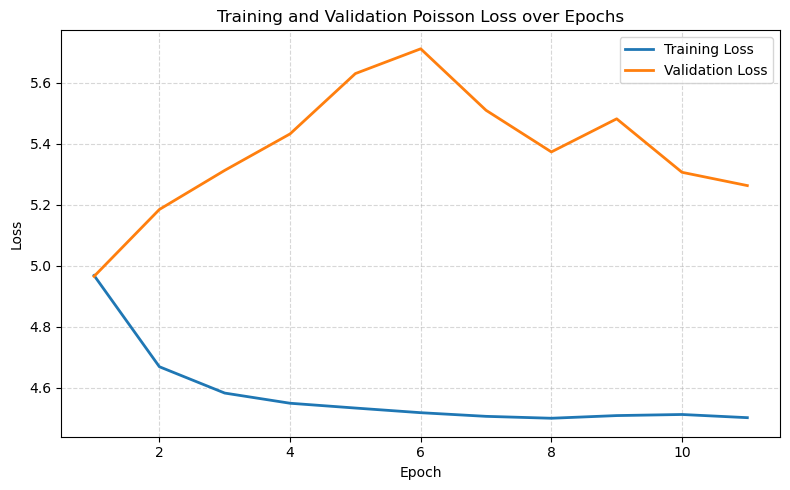

In [29]:
plot_training_history(training_history)


-----------
# 8. Most Exciting Input

In [30]:
# init_std = 0.1
# idx = 50
# l2_lambda = 1e-3

# image = (torch.randn(image_shape, device=device) * init_std).requires_grad_(True)

# l2_reg = l2_lambda * (image ** 2).mean()

# pred = model(image)[0, 0, idx]
# loss = -pred
# res = loss + l2_reg

# res.backward()

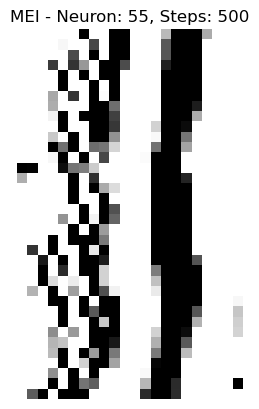

In [42]:
from neuropixel_predictor.mei.generate import generate_mei, plot_mei

device = 'mps'
steps = 500
neuron_idx = 55
image_shape = (1, 1, IMAGE_WIDTH, IMAGE_HEIGHT)

mei = generate_mei(
    model,
    neuron_idx,
    image_shape,
    steps=steps,
    mode="cei",     # or "vei_plus", "vei_minus"
    device=device,
)

plot_mei(mei, title="MEI - Neuron: {}, Steps: {}".format(neuron_idx, steps) )

-----------
# 9. Use MEI in the model

In [45]:
# 1. Fetch a stimulus image from the dataset
random_dataset_indx = torch.randint(training_images.shape[0], (1,))
dataset_image = training_images[random_dataset_indx].to(device)

# 2. Generate a completely random image
random_image = torch.randn(image_shape, device=device) * 0.1

# 3. Test dataset image, random image and MEI image and compare predictions
pred_random = model(random_image)[0, 0, neuron_idx]
pred_dataset = model(dataset_image)[0, 0, neuron_idx]
pred_mei = model(mei)[0, 0, neuron_idx]

pred_random, pred_dataset, pred_mei

(tensor(1.7699, device='mps:0', grad_fn=<SelectBackward0>),
 tensor(0.8613, device='mps:0', grad_fn=<SelectBackward0>),
 tensor(20.1089, device='mps:0', grad_fn=<SelectBackward0>))